In [1]:
from ElephasReader import DataReader
import ElephasReader

In [2]:
import pandas as pd
import pyodbc
import numpy as np
import string
import matplotlib.pyplot as plt
import datetime

In [3]:
import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(offline = True, world_readable=True)

In [4]:
def add_zero(ticker_int):
    """adjust the ticker code to six digit format"""
    ticker_str = str(ticker_int)
    if len(ticker_str) < 6:
        ticker_str = '0' * (6 - len(ticker_str)) + ticker_str
    return ticker_str

# 1. query the data - skip if we want to import csv

## 1.1 zyyx data

In [389]:
db_price = pyodbc.connect('Driver={ODBC Driver 17 for SQL Server};'
                          'Server=192.168.0.157;'
                          'Database=zyyx2;'
                          'UID=sa01;PWD=sa01;')

cursor = db_price.cursor()

In [36]:
sql_index_query = """
SELECT * 
FROM zyyx2.dbo.qt_idx_daily
WHERE 1=1
and index_code IN ('000905', '000300', '399303')
and trade_date > '2012-01-01'
"""

In [37]:
price_index = pd.read_sql(sql_index_query, db_price)
# price index pivot
price_index_df = pd.pivot_table(price_index[["index_code", "trade_date", "tclose"]], "tclose", "trade_date", "index_code")
price_index_df.columns.name = None
return_index_df =  price_index_df.diff() / price_index_df.shift(1)
return_index_df.to_csv("return_index_df.csv")

In [452]:
sql_price_query = """
SELECT trade_date, stock_code, tcap, tclose, matiply_ratio, is_valid, backward_adjratio
FROM zyyx2.dbo.qt_stk_daily
WHERE 1=1
--and stock_code IN ({})
and tcap > 50000
and is_valid = 1
and trade_date > '2012-01-01'
"""

In [453]:
# grab the data and do some adjustment
## price = pd.read_sql(sql_price_query.format(",".join(metadata["ticker"].unique().tolist())), db_price)
price = pd.read_sql(sql_price_query, db_price)
# price.sort_values("trade_date", inplace = True)
price["back_adj"] = price["tclose"] / price["backward_adjratio"]
price["forward_adj"] = price["tclose"] * price["matiply_ratio"]
# price = price[price["stock_code"].isin(metadata["ticker"].unique().tolist())]
# keep a copy
price.to_csv("price.csv")

In [454]:
# price pivot
price_df = pd.pivot_table(price[["stock_code", "trade_date", "forward_adj"]], "forward_adj", "trade_date", "stock_code")
price_df.columns.name = None
price_df = price_df.replace(0.0, np.nan)
# market cap data
tcap_df = pd.pivot_table(price[["stock_code", "trade_date", "tcap"]], "tcap", "trade_date", "stock_code")
## adv_df = pd.pivot_table(price[["stock_code", "trade_date", "amount"]], "amount", "trade_date", "stock_code")

# return data
return_df = price_df.diff() / price_df.shift(1)
return_df_alpha300 = return_df.sub(return_index_df["000300"], axis = 0)
return_df_alpha500 = return_df.sub(return_index_df["000905"], axis = 0)
return_df_alpha2000 = return_df.sub(return_index_df["399303"], axis = 0)

In [32]:
# ipo information
ipo_df = DataReader.get_ipo_date()
ipo_df["ticker"] = ipo_df.apply(lambda x: x["stock_code"][:-3], axis = 1)
ipo_df.to_csv("ipo_df.csv")

In [14]:
sql_industry_query = """
SELECT * 
FROM zyyx2.dbo.qt_indus_constituents
where standard_name = N'申银万国一级行业' and use_status = 1
"""

In [15]:
# grab the data and do some adjustment
industry_df = pd.read_sql(sql_industry_query, db_price)
#keep a copy
industry_df.to_csv("industry_df.csv")

In [387]:
sql_cons_query = """
SELECT x.stock_code, x.con_date, x.con_rating_strength, x.con_rating_type, y.*
FROM zyyx2.dbo.con_rating_stk x
LEFT JOIN zyyx2.dbo.con_forecast_roll_stk y 
ON x.stock_code = y.stock_code AND x.con_date = y.con_date 

WHERE 1=1
-- and x.stock_code IN ({})
and x.con_date > '2012-01-01'
"""

In [390]:
# grab the data and do some adjustment
con_df = pd.read_sql(sql_cons_query, db_price)
#con_df = con_df[con_df["stock_code"].isin(metadata["ticker"].unique().tolist())]
# keep a copy
con_df.iloc[:, 1:].to_csv("con_df.csv")

In [410]:
con_df.to_csv("con_df.csv")

In [392]:
db_price_ys2 = pyodbc.connect('Driver={ODBC Driver 17 for SQL Server};'
                          'Server=192.168.0.157;'
                          'Database=zyyx_ys2;'
                          'UID=sa01;PWD=sa01;')

cursor = db_price_ys2.cursor()

In [393]:
sql_coverage_query = """
SELECT x.stock_code, x.con_date, x.organ_num_q, a.diver
FROM zyyx_ys2.dbo.der_report_num x 
LEFT JOIN (
SELECT stock_code, con_date, avg(eps_diver) as diver
FROM zyyx_ys2.dbo.der_diver_stk 
WHERE YEAR(con_date) = con_year - 1 or YEAR(con_date) = con_year
group by stock_code, con_date ) a 
ON x.stock_code = a.stock_code AND x.con_date = a.con_date 

WHERE 1=1
-- and x.stock_code IN ({})
and x.con_date > '2012-01-01'
"""

In [394]:
# grab the data and do some adjustment
coverage_df = pd.read_sql(sql_coverage_query, db_price_ys2)
#coverage_df = coverage_df[coverage_df["stock_code"].isin(metadata["ticker"].unique().tolist())]
# keep a copy
coverage_df.to_csv("coverage_df.csv")

In [411]:
# combine 
con_df_combined = con_df.merge(coverage_df, how = 'left', on = ["stock_code", "con_date"])
con_df_combined.to_csv("con_df_combined.csv")

## 1.2 jydb data

In [6]:
db_jy = pyodbc.connect('Driver={ODBC Driver 17 for SQL Server};'
                          'Server=192.168.0.157;'
                          'Database=jydb;'
                          'UID=sa01;PWD=sa01;')

cursor = db_jy.cursor()

In [7]:
info_query = """
select *
from jydb.dbo.SecuMain
"""

In [8]:
#earning release data
info_df = pd.read_sql(info_query, db_jy)
info_df.to_csv("info_df.csv")

In [358]:
sql_earning_query = """
(SELECT distinct InfoPublDate, a.EndDate, b.SecuCode, 'Full' as "Type"
FROM jydb.dbo.DZ_IncomeStatementAll a
left join jydb.dbo.SecuMain b
on a.CompanyCode = b.CompanyCode

) 

UNION

(SELECT distinct InfoPublDate, a.EndDate, b.SecuCode, 'Short' as "Type"
FROM jydb.dbo.DZ_FSPerformedLetters a
left join jydb.dbo.SecuMain b
on a.CompanyCode = b.CompanyCode)

UNION

(SELECT distinct InfoPublDate, a.EndDate, b.SecuCode, 'Forecast' as "Type"
FROM jydb.dbo.DZ_PerformanceForecast a
left join jydb.dbo.SecuMain b
on a.CompanyCode = b.CompanyCode)

"""

In [359]:
#earning release data
earning_df = pd.read_sql(sql_earning_query, db_jy)
earning_df.columns = ["publish_date", "end_date", "ticker", "type"]
earning_df.sort_values(["ticker", "end_date", "publish_date"], inplace = True)
#earning_df = earning_df[earning_df["ticker"].isin(metadata["ticker"].unique().tolist())]
earning_df = earning_df[earning_df["publish_date"] > pd.Timestamp(2012,1,1)]


In [361]:

earning_df = earning_df.groupby(["ticker", "end_date"]).apply(lambda x: x.iloc[0])
earning_df = earning_df.set_index("ticker")["publish_date"].reset_index().drop_duplicates()
earning_df = earning_df.sort_values(["ticker", "publish_date"])
# keep a copy
earning_df.to_csv("earning_df.csv")

## 1.3 just import the csv

### index return data

In [5]:
return_index_df = pd.read_csv("return_index_df.csv")
return_index_df["trade_date"] = return_index_df.apply(lambda x: pd.Timestamp(x["trade_date"]), axis = 1)
return_index_df.set_index("trade_date", inplace = True)

### price, return, market cap

In [ ]:
price = pd.read_csv("price.csv")
price["trade_date"] = price.apply(lambda x: pd.Timestamp(x["trade_date"]), axis = 1)
price["stock_code"] = price.apply(lambda x: add_zero(x["stock_code"]), axis = 1)

# price pivot
price_df = pd.pivot_table(price[["stock_code", "trade_date", "forward_adj"]], "forward_adj", "trade_date", "stock_code")
price_df.columns.name = None
price_df = price_df.replace(0.0, np.nan)

# market cap data
tcap_df = pd.pivot_table(price[["stock_code", "trade_date", "tcap"]], "tcap", "trade_date", "stock_code")
## adv_df = pd.pivot_table(price[["stock_code", "trade_date", "amount"]], "amount", "trade_date", "stock_code")

# return data
return_df = price_df.diff() / price_df.shift(1)
return_df_alpha300 = return_df.sub(return_index_df["000300"], axis = 0)
return_df_alpha500 = return_df.sub(return_index_df["000905"], axis = 0)
return_df_alpha2000 = return_df.sub(return_index_df["399303"], axis = 0)

### IPO

In [ ]:
ipo_df = pd.read_csv("ipo_df.csv")
ipo_df["ticker"] = ipo_df.apply(lambda x: add_zero(x["ticker"]), axis = 1)
ipo_df["list_date"] = ipo_df.apply(lambda x: pd.Timestamp(x["list_date"]), axis = 1)
ipo_df["delist_date"] = ipo_df.apply(lambda x: pd.Timestamp(x["delist_date"]), axis = 1)

### ticker info

In [ ]:
info_df = pd.read_csv("info_df.csv")

### industry

In [ ]:
industry_df = pd.read_csv("industry_df.csv")
industry_df["stock_code"] = industry_df.apply(lambda x: add_zero(x["stock_code"]), axis = 1)

### consensus data

In [ ]:
con_df_combined = pd.read_csv("con_df_combined.csv")
con_df_combined["con_date"] = con_df_combined.apply(lambda x: pd.Timestamp(x["con_date"]), axis = 1)
con_df_combined["stock_code"] = con_df_combined.apply(lambda x: add_zero(x["stock_code"]), axis = 1)

### earning event data

In [ ]:
earning_df = pd.read_csv("earning_df.csv")
earning_df["publish_date"] = earning_df.apply(lambda x: pd.Timestamp(x["publish_date"]), axis = 1)
earning_df["ticker"] = earning_df.apply(lambda x: add_zero(x["ticker"]), axis = 1)

# 2. brd metadata

## 2.1 build the metadata from scratch

In [ ]:
# metadata and adjust the ticker to the right format
# only look at the brd data for now
metadata = pd.read_csv("Astock_ECM_BRD_HISTORY_TO_20220316_CN_Meta_COMPANY_RESULT3.csv")
metadata = metadata[metadata["typesOfInvestorRelationsActivities"] == "brd"]
metadata["ticker"] = metadata.apply(lambda x: add_zero(x["Stockcode"]), axis = 1)
metadata = metadata.loc[metadata[["ticker", "publish_date"]].drop_duplicates()]

In [1678]:
nlp = pd.read_csv("BERT_ecm_score.csv")

In [1693]:
metadata = pd.merge(metadata, nlp[["transcriptuniqueid", "label_mean_val"]], how = 'left', on= "transcriptuniqueid")

### - publish date

In [334]:
def publish_date_transform(date_string):
    try:
        date = pd.Timestamp(datetime.datetime.strptime(date_string, "%d/%m/%Y %H:%M:%S"))
    except: 
        date = pd.Timestamp(datetime.datetime.strptime(date_string[:-7], "%d/%m/%Y %H:%M:%S"))
        
    if date.month >= 4 and date.month <= 10:
        date += pd.Timedelta(hours = 7)
    else:
        date += pd.Timedelta(hours = 8)
        
    if date.hour < 14:
        date = date - pd.Timedelta(days = 1)
        
    return pd.Timestamp(date.year, date.month, date.day)
    
        
    

In [335]:
# reassign the roadshow on the weekend back to Friday
metadata["publish_date"] = metadata.apply(lambda x: publish_date_transform(x["publish"]) + \
                                          pd.Timedelta(days = 7 - publish_date_transform(x["publish"]).weekday()) \
                                          if publish_date_transform(x["publish"]).weekday() > 4 else publish_date_transform(x["publish"]),\
                                          axis = 1)

In [336]:
# sort the data
metadata.sort_values(["ticker", "publish_date"], inplace = True)
# remove duplicates
metadata = metadata.loc[metadata[["Stockcode", "publish_date"]].drop_duplicates().index]

### - visitors: number and type

In [214]:
def list_length(string):
    if string == '[]':
        return 0
    else:
        try:
            return len(string.split(","))
        except:
            return 0

In [215]:
metadata["num_visitors"] = metadata["company_names"].apply(lambda x: list_length(x))

In [470]:
def org_in_series(string, org_series):
    if string == "[]" or type(string) == float:
        return False
    for org in org_series:
        if org in string:
            return True
    return False

In [469]:
mutual_list = pd.read_excel("Funds.xlsx", sheet_name = "Mutual", header = 2)["Name"]
broker_list = pd.read_excel("Funds.xlsx", sheet_name = "Securities", header = 2)["Name"]

In [471]:
metadata["mutual"] = metadata.apply(lambda x: org_in_series(x["company_names"], mutual_list), axis = 1)

In [503]:
metadata["broker"] = metadata.apply(lambda x: org_in_series(x["company_names"], broker_list), axis = 1) | metadata.apply(lambda x: '证券' in x["company_names"] if type(x["company_names"]) != float else False, axis = 1)

In [488]:
metadata["foreign"] = metadata.apply(lambda x: org_in_series(x["company_names"], list(string.ascii_lowercase) + list(string.ascii_uppercase)), axis = 1)

### - gap between events

In [ ]:
def last_earning_date(earning_df, ref_date, ticker):
    
    try:
        last_earning_day = earning_df[(earning_df["publish_date"] <= ref_date) & (earning_df["ticker"] == ticker)].iloc[-1]["publish_date"]
        return last_earning_day
    except:
        return None    

In [224]:
def gap_days_since_last_earning(earning_df, ref_date, ticker):
    """
    earning_df needs to be sorted
    return the gap of days between ref_date and last earning
    if the ref_date happens to be an earning, we see it as zero
    """
    try:
        last_earning_day = last_earning_date(earning_df, ref_date, ticker)
#         earning_df[(earning_df["publish_date"] <= ref_date) & (earning_df["ticker"] == ticker)].iloc[-1]["publish_date"]
        return (ref_date - last_earning_day).days
    except:
        return None

In [276]:
def gap_days_to_next_earning(earning_df, ref_date, ticker):
    """
    earning_df needs to be sorted
    return the gap of days between ref_date and next earning
    if the ref_date happens to be an earning, we look to the next
    """
    try:
        next_earning_day = earning_df[(earning_df["publish_date"] > ref_date) & (earning_df["ticker"] == ticker)].iloc[0]["publish_date"]
        return (next_earning_day - ref_date).days
    except:
        return None

In [277]:
# calculate the gap since last meeting
def gap_days_since_last_brd(fundamental_df):
    """
    add the days gap column by doing some dataframe manipulation
    return the panda series to be int where there is data, or None where is no earlier data
    """
    
    fundamental_df_sorted = fundamental_df.sort_values(["ticker", "publish_date"])
    date_diff_timestamp = fundamental_df_sorted["publish_date"] -  fundamental_df_sorted.shift(1)["publish_date"]
    ticker_diff = fundamental_df_sorted["ticker"] ==  fundamental_df_sorted.shift(1)["ticker"]
    
    date_diff_days = date_diff_timestamp.apply(lambda x: x.days if type(x) == pd.Timedelta else None)
    date_diff_days[ticker_diff == False] = None
    return date_diff_days

In [278]:
# calculate the gap since last meeting
def gap_days_brd_shift_diff(fundamental_df, count):
    """
    add the days gap column by doing some dataframe manipulation
    return the panda series to be int where there is data, or None where is no earlier data
    """
    
    fundamental_df_sorted = fundamental_df.sort_values(["ticker", "publish_date"])
    brd_shift = fundamental_df_sorted["days_since_last_brd"].replace(np.nan, 0.0) -  fundamental_df_sorted["days_since_last_brd"].replace(np.nan, 0.0).shift(count)
    ticker_diff = fundamental_df_sorted["ticker"] == fundamental_df_sorted.shift(count)["ticker"]
    
    brd_shift[ticker_diff == False] = None
    return brd_shift

In [279]:
def avg_brd_lookback(fundamental_df, ipo_date, ticker, ref_date, lookback):
    try:
        real_lookback = min(lookback, (ref_date - ipo_date.loc[ticker]).days)
        return fundamental_df[(fundamental_df["ticker"] == ticker) & (fundamental_df["publish_date"] <= ref_date) & (fundamental_df["publish_date"] >= ref_date - pd.Timedelta(days = real_lookback))].shape[0] / real_lookback
    except:
        return None
    
    

In [280]:
def reset_cumsum_above_gap(data_series, gap, diviser):
    """
    reset the cumsum at nan, and divide by a diviser
    params:
        gap - minimum number to reset the cumsum
    """
    v = data_series.copy()
    v[v > gap] = None
    v_fill = v.cumsum().fillna(method = 'pad')
    reset = -v_fill[v.isnull()].diff().fillna(v_fill)
    result = v.where(v.notnull(), reset).cumsum() // diviser
    result[result.isnull()] = 0 # initial consecutive nan to be assigned none, so change to 0
    return result

In [281]:
def reset_count_above_gap(data_series, gap):
    """
    reset the count at nan, and divide by a diviser
    params:
        gap - minimum number to reset the cumsum
    """
    v = data_series.copy()
    v[v > gap] = None
    v[v.notnull()] = 1.0
    v_fill = v.cumsum().fillna(method = 'pad')
    reset = -v_fill[v.isnull()].diff().fillna(v_fill)
    result = v.where(v.notnull(), reset).cumsum()
    result[result.isnull()] = 0 # initial consecutive nan to be assigned none, so change to 0
    return result

In [282]:
def reset_count_after_earning(data_series, earning_series):
    """
    reset the count at nan, and divide by a diviser
    params:
        gap - minimum number to reset the cumsum
    """
    v = data_series.copy()
    v[earning_series.diff() != pd.Timedelta(days=0) ] = None
    v[v.notnull()] = 1.0
    v_fill = v.cumsum().fillna(method = 'pad')
    reset = -v_fill[v.isnull()].diff().fillna(v_fill)
    result = v.where(v.notnull(), reset).cumsum()
    result[result.isnull()] = 0 # initial consecutive nan to be assigned none, so change to 0
    return result

In [283]:
def apply_number(row, num):
    try:
        return row.iloc[num]
    except:
        pass

In [159]:
metadata["days_since_last_brd"] = gap_days_since_last_brd(metadata)

In [322]:
metadata["reset_cumsum_180d_div7"] = metadata.groupby("ticker").apply(lambda x: reset_cumsum_above_gap(x["days_since_last_brd"], 180, 7)).values

In [160]:
metadata["reset_cumsum_120d_div7"] = metadata.groupby("ticker").apply(lambda x: reset_cumsum_above_gap(x["days_since_last_brd"], 120, 7)).values

In [311]:
metadata["reset_count_180d"] = metadata.groupby("ticker").apply(lambda x: reset_count_above_gap(x["days_since_last_brd"], 180)).values

In [166]:
metadata["reset_count_120d"] = metadata.groupby("ticker").apply(lambda x: reset_count_above_gap(x["days_since_last_brd"], 120)).values

In [274]:
metadata["days_since_last_earning"] = metadata.apply(lambda x: gap_days_since_last_earning(earning_df, x["publish_date"], x["ticker"]), axis = 1)

In [284]:
metadata["days_to_next_earning"] = metadata.apply(lambda x: gap_days_to_next_earning(earning_df, x["publish_date"], x["ticker"]), axis = 1)

In [285]:
metadata["position_in_earning"] = metadata["days_since_last_earning"] / (metadata["days_since_last_earning"] + metadata["days_to_next_earning"])

In [286]:
metadata["gap_between_earning"] = metadata["days_since_last_earning"] + metadata["days_to_next_earning"] 

In [289]:
metadata["last_earning"] = metadata.apply(lambda x: x["publish_date"] - pd.Timedelta(days=x["days_since_last_earning"]) if x["days_since_last_earning"] >= 0 else None, axis = 1)

In [291]:
metadata["reset_count_earning"] = metadata.groupby("ticker").apply(lambda x: reset_count_after_earning(x["days_since_last_earning"], x["last_earning"])).values

### - period dummy

In [581]:
# period dummy
metadata["year"] = metadata.apply(lambda x: x["publish_date"].year, axis = 1)
metadata["quarter"] = metadata.apply(lambda x: (x["publish_date"].month - 1) // 3 + 1, axis = 1)
metadata["month"] = metadata.apply(lambda x: x["publish_date"].month, axis = 1)

### - industry dummy

In [102]:
# merge industry information
metadata = pd.merge(metadata, industry_df[["stock_code", "industry_name"]].rename({"stock_code": "ticker"}, axis = 1), how = "left", on = ["ticker"])

### - ipo date

In [171]:
# ipo date
metadata = metadata.merge(ipo_df[["ticker", "list_date", "delist_date"]], on = "ticker", how = "left")

### - factors

#### - size

In [331]:
def calc_df(ticker, ref_date, df) -> float:
    """
    calculate matching data in the dataframe the day before 
    params:
    return_df: index is date in the ref_date format, columns are ticker
    """
    try:
        return df.loc[:ref_date, ticker].iloc[-2]
    except:
        return None

In [170]:
metadata["tcap"] = metadata.apply(lambda x: calc_df(x["ticker"], x["publish_date"], tcap_df), axis = 1)

#### - vol

In [516]:
def calc_vol(ticker, ref_date, look_back: int, return_df) -> float:
    """
    calculate normal volatility with certain look_back, excluding the ref_date
    params:
    return_df: index is date in the ref_date format, columns are ticker
    """
    try:
        return return_df.loc[:ref_date, ticker][-look_back:-1].std()
    except:
        return None

In [517]:
metadata["vol_60d"] = metadata.apply(lambda x: calc_vol(x["ticker"], x["publish_date"], 60, return_df), axis = 1)
metadata["vol_20d"] = metadata.apply(lambda x: calc_vol(x["ticker"], x["publish_date"], 20, return_df), axis = 1)

#### - momentum

In [488]:
# add pre event return data
def calc_back_return(ticker, ref_date, length, leave, return_df):
    """
    calculate the return data from ref_date for a certain length backwards leave a certain days
    """
    try:
        return (1+return_df.loc[:ref_date, ticker].iloc[-int(length) - leave: -leave]).cumprod().ffill().iloc[-1]-1
    except:
        return None
    

In [489]:
metadata["return_alpha500_40d_1d"] = metadata.apply(lambda x: calc_back_return(x["ticker"], x["publish_date"], 40, 1, return_df_alpha500), axis = 1)

In [490]:
metadata["return_alpha500_5d_1d"] = metadata.apply(lambda x: calc_back_return(x["ticker"], x["publish_date"], 5, 1, return_df_alpha500), axis = 1)

In [491]:
metadata["return_abs_20d_1d"] = metadata.apply(lambda x: calc_back_return(x["ticker"], x["publish_date"], 20, 1, return_df), axis = 1)

In [492]:
metadata["return_abs_120d_20d"] = metadata.apply(lambda x: calc_back_return(x["ticker"], x["publish_date"], 120, 10, return_df), axis = 1)

#### - technical

In [362]:
def get_macd(price_df, slow, fast, smooth):
    exp1 = price_df.ewm(span = fast, adjust = False).mean()
    exp2 = price_df.ewm(span = slow, adjust = False).mean()
    dif = exp1 - exp2
    dea = dif.ewm(span = smooth, adjust = False).mean()
    macd = (dif - dea) * 2
    return dif, dea, macd

dif_df, dea_df, macd_df = get_macd(price_df, 30, 10, 15)

In [363]:
metadata["dif"] =  metadata.apply(lambda x: calc_df(x["ticker"], x["publish_date"], dif_df), axis = 1)
metadata["dea"] =  metadata.apply(lambda x: calc_df(x["ticker"], x["publish_date"], dea_df), axis = 1)
metadata["macd"] =  metadata.apply(lambda x: calc_df(x["ticker"], x["publish_date"], macd_df), axis = 1)

In [353]:
from typing import Callable

# Define function to calculate the RSI
def calc_rsi(over: pd.Series, fn_roll: Callable) -> pd.Series:
    # Get the difference in price from previous step
    delta = over.diff()
    # Get rid of the first row, which is NaN since it did not have a previous row to calculate the differences
    delta = delta[1:] 

    # Make the positive gains (up) and negative gains (down) Series
    up, down = delta.clip(lower=0), delta.clip(upper=0).abs()

    roll_up, roll_down = fn_roll(up), fn_roll(down)
    rs = roll_up / roll_down
    rsi = 100.0 - (100.0 / (1.0 + rs))

    # Avoid division-by-zero if `roll_down` is zero
    # This prevents inf and/or nan values.
    rsi[:] = np.select([roll_down == 0, roll_up == 0, True], [100, 0, rsi])

    # Assert range
    valid_rsi = rsi[length - 1:]
#     assert ((0 <= valid_rsi) & (valid_rsi <= 100)).all()
    # Note: rsi[:length - 1] is excluded from above assertion because it is NaN for SMA.

    return rsi

# Calculate RSI using MA of choice
# Reminder: Provide ≥ `1 + length` extra data points!
rsi_df = calc_rsi(price_df, lambda s: s.ewm(span=20).mean())


In [355]:
metadata["rsi"] =  metadata.apply(lambda x: calc_df(x["ticker"], x["publish_date"], rsi_df), axis = 1)

In [372]:
def PSY(df, N):  
    return (price_df > price_df.shift(1)).rolling(N).sum()/N * 100

psy_df = PSY(price_df, 20)

In [374]:
metadata["psy"] =  metadata.apply(lambda x: calc_df(x["ticker"], x["publish_date"], psy_df), axis = 1)

In [381]:
def BIAS(df, N):  
    return (df - df.rolling(N).mean())/df.rolling(N).mean() * 100

bias_df = BIAS(price_df, 20)

In [382]:
metadata["bias"] =  metadata.apply(lambda x: calc_df(x["ticker"], x["publish_date"], bias_df), axis = 1)

In [385]:
def BOLL(df, N):
    return (df - df.rolling(N).mean()) / df.rolling(N).std()
boll_df = BOLL(price_df, 20)

In [386]:
metadata["boll"] =  metadata.apply(lambda x: calc_df(x["ticker"], x["publish_date"], boll_df), axis = 1)

#### - consensus revision

In [541]:
# add pre event change data
def calc_back_change(ticker, ref_date, look_back, con_df, column_name):
    """
    calculate the return data from ref_date for a certain lookback 
    """
    try:
        data_df = con_df[con_df["stock_code"] == ticker]
        data_series = data_df[["con_date", column_name]].set_index("con_date").loc[:ref_date, column_name].iloc[-int(look_back):].bfill().ffill()
        return (data_series.iloc[-1] - data_series.iloc[0]) / abs(data_series.iloc[0])
        
            
    except:
        return None
    

In [559]:
eps_df = pd.pivot_table(con_df_combined[["stock_code","con_date", "con_eps_roll"]], values = "con_eps_roll", index = "con_date", columns = "stock_code")
eps_return = eps_df.diff()/eps_df.shift(1)

In [ ]:
# metadata["eps_upgrade_40d"] = metadata.apply(lambda x: calc_back_change(x["ticker"], x["publish_date"], 40, con_df, "con_eps_roll"), axis = 1)

In [560]:
metadata["eps_revision_40d_1d"] = metadata.apply(lambda x: calc_back_return(x["ticker"], x["publish_date"], 40, 1, eps_return), axis = 1)

#### - valuation

In [408]:
# add post event return data
def calc_forward_return(ticker, ref_date, entry_delay, look_forward, return_df):
    """
    calculate the return data from ref_date for a certain period forward 
    entry_delay 1 means get on the position at T+1, so start calculating raturn at T+2
    """
    try:
        return (1+return_df.loc[ref_date:, ticker].iloc[1+entry_delay:1+entry_delay+look_forward]).cumprod().ffill().iloc[-1]-1
    except:
        return None
    

In [470]:
# merge con value data
def merge_con_value(fundamental_df, con_df, metrics) -> pd.DataFrame:
    """
    grab the specific consensus value
    con_pe_roll: rolling pe
    con_peg_roll: rolling peg
    con_npcgrate_2y_roll: rolling two year cagr
    con_or_yoy_roll: rolling top line yoy
    con_np_yoy_roll: rolling bottom line yoy
    metrics: list of columns
    """
    
    ratio_df = con_df[["stock_code", "con_date"] + metrics].rename({"stock_code": "ticker", "con_date": "publish_date"}, axis = 1)
    return pd.merge(fundamental_df, ratio_df, how = "left", on = ["ticker", "publish_date"])

 

In [471]:
metadata = merge_con_value(metadata, con_df_combined, con_df_combined.columns[con_df_combined.columns.tolist().index("con_date")+1:].tolist() + ["con_rating_strength", "con_rating_type"])

### - export the data

In [1677]:
# keep a copy
metadata.to_csv("metadata.csv")

## 2.2 if we just want to import the dataframe

In [18]:
metadata = pd.read_csv("metadata.csv")
metadata["publish_date"] = metadata.apply(lambda x: pd.Timestamp(x["publish_date"]), axis = 1)
metadata["list_date"] = metadata.apply(lambda x: pd.Timestamp(x["list_date"]), axis = 1)
metadata["delist_date"] = metadata.apply(lambda x: pd.Timestamp(x["delist_date"]), axis = 1)
metadata["ticker"] = metadata.apply(lambda x: add_zero(x["ticker"]), axis = 1)

# 3. data exploration


- data from Jul2012 to Feb2022 
- 3146 stocks in total
- all broker meetings not earning call
- if two meetings happen on the same day, treat it as one

### - market cap is concentrated < 100 亿
- median is 70 亿
- min is 6 亿
- mean is 180 亿 (heavy skew to the right

In [68]:
metadata["tcap"].describe()

count    6.775600e+04
mean     1.780633e+06
std      3.902859e+06
min      6.840000e+04
25%      4.422710e+05
50%      7.804677e+05
75%      1.646574e+06
max      1.687997e+08
Name: tcap, dtype: float64

In [ ]:
# # number of meetings distribution
# (metadata.sort_values("tcap")["tcap"].dropna().iloc[:-1000]/10000).iplot(kind = "histogram", 
#                                 bins = 200, 
#                                 theme = "white", 
#                                 title = "distribution of market cap",
#                                 xTitle = 'total market cap at the time of meeting', 
#                                 yTitle = 'count of meetings')

### - industry distribution

In [ ]:
number_of_stocks_by_industry = metadata.groupby("industry_name")["ticker"].apply(lambda x: x.unique().shape[0])

In [ ]:
# metadata.groupby("industry_name").apply(len).sort_values().iplot(kind = "bar",
#                                          title = "number of total meetings by industry")

In [ ]:
# (metadata.groupby("industry_name").apply(len) / number_of_stocks_by_industry).sort_values().iplot(kind = "bar",
#                                          title = "avg number of meetings per company by industry")

### - 60d at the time of meeting

In [ ]:
metadata.sort_values("vol_60d")["vol_60d"].dropna().describe()

In [ ]:
# (metadata.sort_values("vol_60d")["vol_60d"].dropna().iloc[50:-50]).iplot(kind = "histogram", 
#                                 bins = 100, 
#                                 theme = "white", 
#                                 title = "distribution of 60d vol",
#                                 xTitle = '60d vol at the time of meeting', 
#                                 yTitle = 'count of meetings')

### - most common PE is 15-25 at the time of meeting

In [ ]:
metadata.sort_values("con_pe_roll")["con_pe_roll"].dropna().describe()

In [ ]:
# (metadata.sort_values("con_pe_roll")["con_pe_roll"].dropna().iloc[500:-500]).iplot(kind = "histogram", 
#                                 bins = 100, 
#                                 theme = "white", 
#                                 title = "distribution of consensus PE",
#                                 xTitle = 'rolling consensus PE at the time of meeting', 
#                                 yTitle = 'count of meetings')

### -  consensus NP growth, no obvious growth bias

In [ ]:
metadata.sort_values("con_np_yoy_roll")["con_np_yoy_roll"].dropna().describe()

In [ ]:
# (metadata.sort_values("con_np_yoy_roll")["con_np_yoy_roll"].dropna().iloc[500:-500]).iplot(kind = "histogram", 
#                                 bins = 100, 
#                                 theme = "white", 
#                                 title = "distribution of consensus NP growth",
#                                 xTitle = 'rolling consensus NP growth at the time of meeting', 
#                                 yTitle = 'count of meetings')

### - more than 40% companies have less than 10 broker meetings

In [ ]:
# # number of meetings distribution
# metadata.groupby("ticker").apply(lambda x: len(x)).sort_values().iplot(kind = "histogram", 
#                                 bins = 40, 
#                                 theme = "white", 
#                                 title = "distribution of broker meeting counts per stock",
#                                 xTitle = 'number of meetings', 
#                                 yTitle = 'count of stocks')

### - number of meetings are relatively stable across years

In [ ]:
# metadata.groupby("year").apply(len).iplot(kind = "bar",
#                                           theme = 'white',
#                                          title = "number of meetings per year")

### - some seasonality but 2012 and 2022 don't have full Q1 data

In [ ]:
# metadata.groupby("quarter").apply(len).iplot(kind = "bar",
#                                          title = "number of meetings each quarter")

In [ ]:
# metadata.groupby("month").apply(len).iplot(kind = "bar",
#                                          title = "number of meetings each month")

### - time gap between meetings and versus earning releases

In [ ]:
metadata["days_since_last_brd"].describe()

In [ ]:
# # days_since_last_brd distribution
# metadata["days_since_last_brd"].dropna().sort_values()[:-2000].iplot(kind = "histogram", 
#                                 bins = 400, 
#                                 theme = "white", 
#                                 title = "days since last meeting distribution",
#                                 xTitle = 'days since last meeting', 
#                                 yTitle = 'count of instances')

In [ ]:
# # days_since_last_earning distribution
# metadata["days_since_last_earning"].dropna().sort_values()[:-50].iplot(kind = "histogram", 
#                                 bins = 100, 
#                                 theme = "white", 
#                                 title = "days since last earning distribution",
#                                 xTitle = 'days since last earning', 
#                                 yTitle = 'count of instances')

In [ ]:
# # days_to_next_earning distribution
# metadata["days_to_next_earning"].dropna().sort_values()[:-50].iplot(kind = "histogram", 
#                                 bins = 100, 
#                                 theme = "white", 
#                                 title = "days till next earning distribution",
#                                 xTitle = 'days till next earning', 
#                                 yTitle = 'count of instances')

### - return before the brd meeting

In [ ]:
metadata["return_alpha500_20d"].describe()

In [ ]:
metadata["return_alpha500_40d"].describe()

In [ ]:
metadata["return_alpha500_last_brd"].describe()

In [ ]:
metadata["return_alpha500_last_earning"].describe()

In [ ]:
metadata["return_alpha500_40d"].sort_values().dropna()

In [ ]:
# # alpha return 20d
# metadata["return_alpha500_20d"].dropna().sort_values()[:-200].iplot(kind = "histogram", 
#                                 bins = 100, 
#                                 theme = "white", 
#                                 title = "alpha return 20d before the meeting",
#                                 xTitle = 'alpha return 20d', 
#                                 yTitle = 'count of instances')

In [ ]:
# # alpha return 40d
# metadata["return_alpha500_40d"].dropna().sort_values()[:-200].iplot(kind = "histogram", 
#                                 bins = 100, 
#                                 theme = "white", 
#                                 title = "alpha return 40d before the meeting",
#                                 xTitle = 'alpha return 40d', 
#                                 yTitle = 'count of instances')

In [ ]:
# # alpha return from last brd
# metadata["return_alpha500_last_brd"].dropna().sort_values()[:-200].iplot(kind = "histogram", 
#                                 bins = 200, 
#                                 theme = "white", 
#                                 title = "alpha return from last brd",
#                                 xTitle = 'alpha return', 
#                                 yTitle = 'count of instances')

In [ ]:
# # alpha return from last earning
# metadata["return_alpha500_last_earning"].dropna().sort_values()[:-200].iplot(kind = "histogram", 
#                                 bins = 200, 
#                                 theme = "white", 
#                                 title = "alpha return from last earning",
#                                 xTitle = 'alpha return', 
#                                 yTitle = 'count of instances')

# 4. event trades research/analytics

In [260]:
def get_if_limit_up(ticker, list_date, return_df, trade_date):
    
    try:
        return_pct = return_df.loc[trade_date, ticker]
    except:
        print("no such index")
        return None
    
    if return_pct < 0: #circuit breakif below 0%
        return False
    
    stock_code = ElephasReader.utils.normalize_stkcode(ticker)
    trade_date_5d_off = trade_date - pd.Timedelta(days = 7)
#     is_st = kwargs['is_st']

    # 判断最大涨幅
    limit_pct = 10
    if stock_code[-2:] == 'NE':  # 北交所
        if list_date == trade_date:
            limit_pct = 0
        else:
            limit_pct = 30
    elif stock_code[:2] == '68':  # 科创板
        if (list_date > trade_date_5d_off) and (list_date <= trade_date):
            limit_pct = 0
        else:
            limit_pct = 20
    elif stock_code[:2] == '30' and trade_date >= pd.Timestamp(2020, 8, 24):  # 创业板
        if (list_date > trade_date_5d_off) and (list_date <= trade_date):
            limit_pct = 0
        else:
            limit_pct = 20
    else:
        if trade_date > pd.Timestamp(2014, 6, 13) and trade_date == list_date:  # 其他情况上市首日
            limit_pct = 44

#         if is_st == 1:  # st股
#             limit_pct = 5

    if limit_pct == 0:
        return False

    if return_pct < limit_pct / 100 - 0.0001:
        return False
    else:
        return True

In [261]:
def quantile_score(data_series, bins):
    data_series_copy = data_series.copy()
    
    for i in range(1, bins + 1):
        if i == bins:
            data_series_copy[(data_series >= data_series.quantile((i-1)/bins)) & (data_series <= data_series.quantile(i/bins))] = i
        else:
            data_series_copy[(data_series >= data_series.quantile((i-1)/bins)) & (data_series < data_series.quantile(i/bins))] = i
    return data_series_copy

In [262]:
def quantile_analysis_plot(trade_return_df, bins, column_name, return_column):
    growth_analysis = pd.concat([quantile_score(trade_return_df[column_name], bins),trade_return_df[return_column]], axis = 1)
    growth_analysis.columns = [column_name, "return"]
    growth_analysis.groupby(column_name)["return"].apply(lambda x: x.mean()).sort_index().iplot(kind = "bar",
                                            theme = 'white',
                                            xTitle = "score",
                                            yTitle = "return per trade",
                                            title = "average return per trade by " + column_name)

In [263]:
def trade_return_series(return_df, ticker, ref_date, holding, entry_delay):
    """
    return the pandas series with return data as values and days of holding as index
    entry delay is to have entry at close in mind, as we shift the return one morem so day 1 is the close to close return
    on the day after the entry day
    """
    data_series = return_df.loc[:, ticker].shift(-entry_delay - 1).loc[ref_date:].iloc[:holding]
    trade_date = data_series.index[:2]
    data_series.index = range(entry_delay, data_series.shape[0] + entry_delay)
    return trade_date, data_series

In [264]:
def generate_trade_analytics_df(metadata, return_df, abs_return_df, holding, entry_delay, column_list):
    """
    return the dataframe with tuple of fundamental information as columns, and days of holding as index
    
    entry delay is to have entry at close in mind, as we shift the return one morem so day 1 is the close to close return
    on the day after the entry day
    """
    
    trade_analytics_dict = {}
    for i in metadata.index:
        target_row = metadata.loc[i]
        info_list = []
        for col in column_list:
            info_list.append(target_row[col])
        
        try:
            trade_date, data_series = trade_return_series(return_df, target_row["ticker"], target_row["publish_date"], holding, entry_delay)
            if get_if_limit_up(target_row["ticker"], target_row["list_date"], abs_return_df, trade_date[0]) and get_if_limit_up(target_row["ticker"], target_row["list_date"], abs_return_df, trade_date[1]):
                pass
            else:
                if get_if_limit_up(target_row["ticker"], target_row["list_date"], abs_return_df, trade_date[0]):
                    trade_analytics_dict[tuple(info_list)] = data_series.shift(-1)
                else:
                    trade_analytics_dict[tuple(info_list)] = data_series
        except:
            pass
        
    trade_analytics_df = pd.DataFrame(trade_analytics_dict)
    return trade_analytics_df


## 4.1 return series

### - by days

In [1694]:
trade_analytics_alpha300_df = generate_trade_analytics_df(metadata, return_df_alpha300, return_df, 40, -5, metadata.columns[metadata.columns.tolist().index("ticker"):])
# trade_analytics_alpha300_df_small = trade_analytics_alpha300_df.loc[:, trade_analytics_alpha300_df.apply(lambda x: x.name[9], axis = 0) < metadata["tcap"].quantile(0.5)]
trade_analytics_alpha300_df_large = trade_analytics_alpha300_df.loc[:, trade_analytics_alpha300_df.apply(lambda x: x.name[metadata.columns[metadata.columns.tolist().index("ticker"):].tolist().index("tcap")], axis = 0) > metadata["tcap"].quantile(0.5)]

In [1695]:
trade_analytics_alpha500_df = generate_trade_analytics_df(metadata, return_df_alpha500, return_df, 40, -5, metadata.columns[metadata.columns.tolist().index("ticker"):])
trade_analytics_alpha500_df_small = trade_analytics_alpha500_df.loc[:, trade_analytics_alpha500_df.apply(lambda x: x.name[metadata.columns[metadata.columns.tolist().index("ticker"):].tolist().index("tcap")], axis = 0) < metadata["tcap"].quantile(0.5)]
# trade_analytics_alpha500_df_large = trade_analytics_alpha500_df.loc[:, trade_analytics_alpha500_df.apply(lambda x: x.name[9], axis = 0) > metadata["tcap"].quantile(0.5)]

In [1696]:
trade_analytics_alpha2000_df = generate_trade_analytics_df(metadata, return_df_alpha2000, return_df, 40, -5, metadata.columns[metadata.columns.tolist().index("ticker"):])
trade_analytics_alpha2000_df_small = trade_analytics_alpha2000_df.loc[:, trade_analytics_alpha2000_df.apply(lambda x: x.name[metadata.columns[metadata.columns.tolist().index("ticker"):].tolist().index("tcap")], axis = 0) < metadata["tcap"].quantile(0.5)]

### - convert into dataframe with return data and feature vectors

In [1697]:
trade_alpha300_return_df = pd.concat([trade_analytics_alpha300_df.loc[1:11].sum(axis = 0), 
                                      trade_analytics_alpha300_df.loc[1:16].sum(axis = 0), 
                                      trade_analytics_alpha300_df.loc[1:21].sum(axis = 0), 
                                      trade_analytics_alpha300_df.loc[1:].sum(axis = 0)], axis = 1).reset_index()

trade_alpha300_return_df.columns = metadata.columns[metadata.columns.tolist().index("ticker"):].tolist() + ["return_post_10d", "return_post_15d","return_post_20d", "return_post_30d"]

In [1698]:
trade_alpha300_return_df_large = pd.concat([trade_analytics_alpha300_df_large.loc[1:11].sum(axis = 0), 
                                            trade_analytics_alpha300_df_large.loc[1:16].sum(axis = 0), 
                                            trade_analytics_alpha300_df_large.loc[1:21].sum(axis = 0), 
                                            trade_analytics_alpha300_df_large.loc[1:].sum(axis = 0)], axis = 1).reset_index()

trade_alpha300_return_df_large.columns = metadata.columns[metadata.columns.tolist().index("ticker"):].tolist() + ["return_post_10d", "return_post_15d", "return_post_20d", "return_post_30d"]

In [1699]:
trade_alpha500_return_df = pd.concat([trade_analytics_alpha500_df.loc[1:11].sum(axis = 0), 
                                      trade_analytics_alpha500_df.loc[1:21].sum(axis = 0), 
                                      trade_analytics_alpha500_df.loc[1:16].sum(axis = 0), 
                                      trade_analytics_alpha500_df.loc[1:].sum(axis = 0)], axis = 1).reset_index()

trade_alpha500_return_df.columns = metadata.columns[metadata.columns.tolist().index("ticker"):].tolist() + ["return_post_10d", "return_post_15d", "return_post_20d", "return_post_30d"]

In [1700]:
trade_alpha500_return_df_small = pd.concat([trade_analytics_alpha500_df_small.loc[1:11].sum(axis = 0), 
                                            trade_analytics_alpha500_df_small.loc[1:16].sum(axis = 0), 
                                      trade_analytics_alpha500_df_small.loc[1:21].sum(axis = 0), 
                                      trade_analytics_alpha500_df_small.loc[1:].sum(axis = 0)], axis = 1).reset_index()

trade_alpha500_return_df_small.columns = metadata.columns[metadata.columns.tolist().index("ticker"):].tolist() + ["return_post_10d", "return_post_15d", "return_post_20d", "return_post_30d"]

In [1701]:
trade_alpha2000_return_df = pd.concat([trade_analytics_alpha2000_df.loc[1:11].sum(axis = 0), 
                                       trade_analytics_alpha2000_df.loc[1:16].sum(axis = 0), 
                                      trade_analytics_alpha2000_df.loc[1:21].sum(axis = 0), 
                                      trade_analytics_alpha2000_df.loc[1:].sum(axis = 0)], axis = 1).reset_index()

trade_alpha2000_return_df.columns = metadata.columns[metadata.columns.tolist().index("ticker"):].tolist() + ["return_post_10d", "return_post_15d","return_post_20d", "return_post_30d"]

In [1702]:
trade_alpha2000_return_df_small = pd.concat([trade_analytics_alpha2000_df_small.loc[1:11].sum(axis = 0), 
                                             trade_analytics_alpha2000_df_small.loc[1:16].sum(axis = 0),
                                      trade_analytics_alpha2000_df_small.loc[1:21].sum(axis = 0), 
                                      trade_analytics_alpha2000_df_small.loc[1:].sum(axis = 0)], axis = 1).reset_index()

trade_alpha2000_return_df_small.columns = metadata.columns[metadata.columns.tolist().index("ticker"):].tolist() + ["return_post_10d", "return_post_15d","return_post_20d", "return_post_30d"]

In [1703]:
trade_alpha_return_df = trade_alpha300_return_df_large.append(trade_alpha500_return_df_small).reset_index(drop = True)

## 4.2 feature review

### - alpha decay: alpha shrinks over time, but small cap shows alpha til day 10-15
- whole universe has around 9bps abs return and 5bps alpha per day in the time period, this is the benchmark
- small cap universe has around 8bps abs return and 4bps alpha per day
- large cap universe has around 11bps abs return and 8bps alpha per day
- vs 2000: whole universe 4bps alpha and small cap 3bps alpha

In [312]:
broker_trade_analytics_alpha500_df_small.mean(axis = 1).iplot(kind = "bar",
                                        theme = 'white',
                                        xTitle = "day",
                                        yTitle = "return per trade",
                                        title = "small cap alpha vs 500 per trade by day")

In [313]:
broker_trade_analytics_alpha300_df_large.mean(axis = 1).iplot(kind = "bar",
                                        theme = 'white',
                                        xTitle = "day",
                                        yTitle = "return per trade",
                                        title = "small cap alpha vs 500 per trade by day")

In [137]:
trade_analytics_alpha500_df.mean(axis = 1).iplot(kind = "bar",
                                        theme = 'white',
                                        xTitle = "day",
                                        yTitle = "return per trade",
                                        title = "small cap alpha vs 500 per trade by day")

In [1812]:
trade_analytics_alpha500_df_small.mean(axis = 1).iplot(kind = "bar",
                                        theme = 'white',
                                        xTitle = "day",
                                        yTitle = "return per trade",
                                        title = "small cap alpha vs 500 per trade by day")

### - institutions: number, type

In [140]:
trade_alpha2000_return_df_small["num_visitors"].describe()

count    33604.000000
mean         4.634002
std          7.999121
min          0.000000
25%          1.000000
50%          2.000000
75%          5.000000
max        389.000000
Name: num_visitors, dtype: float64

In [141]:
quantile_analysis_plot(trade_alpha300_return_df_large, 5, "num_visitors", "return_post_10d")

In [142]:
quantile_analysis_plot(trade_alpha500_return_df_small, 5, "num_visitors", "return_post_10d")

### - return by year

In [87]:
trade_alpha500_return_df_small.groupby("year")["return_post_15d"].apply(lambda x: x.mean()).apply(np.mean).iplot(kind = "bar",
                                        theme = 'white',
                                        xTitle = "year",
                                        yTitle = "alpha per trade",
                                        title = "small cap alpha per trade by year")

### - return by quarter: Q3&4 have seasonally weaker performance

In [88]:
trade_alpha500_return_df_small.groupby("quarter")["return_post_15d"].apply(lambda x: x.mean()).apply(np.mean).iplot(kind = "bar",
                                        theme = 'white',
                                        xTitle = "quarter",
                                        yTitle = "return per trade",
                                        title = "return per trade by quarter")

### - return by month: similar to quarterly seasonality

In [90]:
trade_alpha500_return_df_small.groupby("month")["return_post_15d"].apply(lambda x: x.mean()).apply(np.mean).iplot(kind = "bar",
                                        theme = 'white',
                                        xTitle = "month",
                                        yTitle = "return per trade",
                                        title = "return per trade by month")

### - industry: majority of industries have positive return

In [139]:
trade_alpha500_return_df_small.groupby("industry_name")["return_post_10d"].apply(lambda x: x.mean()).apply(np.mean).sort_values().iplot(kind = "bar",
                                        theme = 'white',
                                        xTitle = "industry",
                                        yTitle = "alpha per trade",
                                        title = "alpha per trade by industry")

### - return by position in earning

In [91]:
trade_alpha500_return_df_small["position_in_earning"].describe()

count    26392.000000
mean         0.446915
std          0.374447
min          0.000000
25%          0.065799
50%          0.372501
75%          0.868863
max          0.999713
Name: position_in_earning, dtype: float64

In [92]:
quantile_analysis_plot(trade_alpha300_return_df_large, 4, "position_in_earning", "return_post_10d")

In [96]:
quantile_analysis_plot(trade_alpha500_return_df_small, 4, "position_in_earning", "return_post_15d")

In [1704]:
trade_alpha300_return_df_large.columns

Index(['ticker', 'publish_date', 'tcap', 'num_visitors', 'days_since_last_brd',
       'year', 'quarter', 'month', 'list_date', 'delist_date',
       'days_since_last_earning', 'days_to_next_earning',
       'position_in_earning', 'gap_between_earning', 'return_alpha500_40d',
       'return_alpha500_5d', 'reset_count_180d', 'reset_cumsum_180d_div7',
       'mutual', 'broker', 'foreign', 'industry_name', 'last_earning',
       'reset_count_earning', 'macd', 'rsi', 'dif', 'dea', 'psy', 'bias',
       'boll', 'con_or_roll', 'con_np_roll', 'con_eps_roll', 'con_na_roll',
       'con_pb_roll', 'con_ps_roll', 'con_pe_roll', 'con_peg_roll',
       'con_roe_roll', 'con_npcgrate_2y_roll', 'con_or_yoy_roll',
       'con_np_yoy_roll', 'entrytime', 'updatetime', 'tmstamp', 'organ_num_q',
       'diver', 'con_rating_strength', 'con_rating_type',
       'return_alpha500_40d_1d', 'return_alpha500_5d_1d', 'return_abs_20d_1d',
       'return_abs_120d_20d', 'vol_60d', 'vol_20d', 'eps_revision_40d_1d',
  

In [1713]:
trade_alpha500_return_df_small[trade_alpha500_return_df_small["label_mean_val"].isna()]["return_post_10d"].mean()

0.007998352717689079

In [1709]:
quantile_analysis_plot(trade_alpha500_return_df_small, 10, "label_mean_val", "return_post_10d")

### - return by days since last brd: similar trend as since last meeting but less significant

In [99]:
trade_alpha500_return_df_small["days_since_last_brd"].describe()

count    31388.000000
mean        90.004874
std        186.143350
min          1.000000
25%          9.000000
50%         30.000000
75%         86.000000
max       3409.000000
Name: days_since_last_brd, dtype: float64

In [97]:
quantile_analysis_plot(trade_alpha300_return_df_large,5,"days_since_last_brd", "return_post_10d")

In [98]:
quantile_analysis_plot(trade_alpha500_return_df_small, 5, "days_since_last_brd", "return_post_10d")

### - reset cumsum and count after a gap

In [187]:
trade_alpha500_return_df_small["reset_count_180d"].describe()

count    33604.000000
mean        12.916706
std         22.971023
min          0.000000
25%          1.000000
50%          5.000000
75%         14.000000
max        246.000000
Name: reset_count_180d, dtype: float64

In [533]:
trade_alpha500_return_df_small.groupby("reset_count_earning")["return_post_10d"].apply(lambda x: x.shape[0]).iloc[:20].iplot(kind="bar")

In [532]:
trade_alpha500_return_df_small.groupby("reset_count_earning")["return_post_10d"].mean().loc[:20].iplot(kind="bar")

In [517]:
trade_alpha500_return_df_small.groupby("reset_count_180d")["return_post_10d"].apply(lambda x: x.shape[0]).loc[:40].iplot(kind="bar",title="reset_count_180d sample size")

In [513]:
trade_alpha500_return_df_small.groupby("reset_count_180d")["return_post_10d"].mean().loc[:40].iplot(kind="bar",title="reset_count_180d return")

In [523]:
trade_alpha500_return_df_small.groupby("reset_cumsum_180d_div7")["return_post_10d"].apply(lambda x: x.shape[0]).loc[:40].iplot(kind = "bar",
                                                                                                                              title = "reset_cumsum_180d_div7 sample size")

In [522]:
trade_alpha500_return_df_small.groupby("reset_cumsum_180d_div7")["return_post_10d"].mean().loc[:40].iplot(kind="bar", title = "reset_cumsum_180d_div7 return")

In [210]:
quantile_analysis_plot(trade_alpha500_return_df_small, 10, "reset_count_180d", "return_post_10d")

In [193]:
quantile_analysis_plot(trade_alpha500_return_df_small, 10, "reset_cumsum_120d_div7", "return_post_10d")

### - return by market cap: small cap outperforms

In [84]:
trade_alpha500_return_df["tcap"].describe()

count    6.713200e+04
mean     1.803447e+06
std      4.044743e+06
min      6.840000e+04
25%      4.489248e+05
50%      7.869937e+05
75%      1.664772e+06
max      1.687997e+08
Name: tcap, dtype: float64

In [83]:
quantile_analysis_plot(trade_alpha500_return_df,5,"tcap", "return_post_10d")

### - vol: different profile for different return measure, vs 500 it seems not much different

In [530]:
trade_alpha500_return_df_small["vol_60d"].describe()

count    33551.000000
mean         0.030744
std          0.012436
min          0.000000
25%          0.022237
50%          0.028161
75%          0.036192
max          0.165650
Name: vol_60d, dtype: float64

In [534]:
quantile_analysis_plot(trade_alpha300_return_df_large, 5, "vol_60d", "return_post_10d")

In [533]:
quantile_analysis_plot(trade_alpha500_return_df_small, 5, "vol_60d", "return_post_10d")

### - PE: there seems to be some value bias, expensive stocks perform less well

In [ ]:
trade_alpha2000_return_df_small["con_pe_roll"].describe()

In [ ]:
quantile_analysis_plot(trade_alpha500_return_df_small, 5, "con_pe_roll", "return_post_10d")

### - growth: a little bit growth bias but tiny

In [ ]:
trade_abs_return_df_5d["con_np_yoy_roll"].describe()

In [ ]:
def growth_analysis_plot(trade_return_df):
    growth_analysis = pd.concat([quantile_score(trade_return_df["con_np_yoy_roll"]),trade_return_df["return_post"]], axis = 1)
    growth_analysis.columns = ["con_np_yoy_roll", "return"]
    growth_analysis.groupby("con_np_yoy_roll")["return"].apply(lambda x: x.mean()).sort_index().iplot(kind = "bar",
                                            theme = 'white',
                                            xTitle = "growth score",
                                            yTitle = "return per trade",
                                            title = "average return per trade by growth")

In [ ]:
growth_analysis_plot(trade_alpha500_return_df_10d_small)

In [ ]:
growth_analysis_plot(trade_alpha2000_return_df_10d_small)

### - PS

In [ ]:
trade_alpha2000_return_df_10d_small["con_ps_roll"].describe()

In [ ]:
quantile_analysis_plot(trade_alpha500_return_df_small, 5, "con_ps_roll", "return_post_10d")

### - PEG

In [ ]:
trade_alpha2000_return_df_small["con_peg_roll"].describe()

In [ ]:
quantile_analysis_plot(trade_alpha500_return_df_small, 5, "con_peg_roll", "return_post_10d")

### - Top line growth

In [ ]:
trade_alpha2000_return_df_small["con_or_yoy_roll"].describe()

In [ ]:
trade_alpha2000_return_df_small[trade_alpha2000_return_df_small["con_or_yoy_roll"].isna()]["return_post_10d"].mean()

In [ ]:
quantile_analysis_plot(trade_alpha500_return_df_small, 5, "con_or_yoy_roll", "return_post_10d")

### - analyst strength: doesn't seem to have a power

In [ ]:
trade_alpha2000_return_df_small["con_rating_strength"].describe()

In [ ]:
trade_alpha2000_return_df_small[trade_alpha2000_return_df_small["con_rating_strength"].isna()]["return_post_10d"].mean()

In [ ]:
quantile_analysis_plot(trade_alpha500_return_df_small, 5, "con_rating_strength", "return_post_10d")

### - EPS: 

In [576]:
quantile_analysis_plot(trade_alpha500_return_df_small, 5, "eps_revision_40d_1d", "return_post_10d")

### - analyst coverage: up to 6 doesn't change much, over that decreases the return

In [577]:
trade_alpha500_return_df_small["organ_num_q"].describe()

count    33326.000000
mean         4.185171
std          4.703750
min          0.000000
25%          1.000000
50%          3.000000
75%          6.000000
max         34.000000
Name: organ_num_q, dtype: float64

In [578]:
quantile_analysis_plot(trade_alpha500_return_df_small, 5, "organ_num_q", "return_post_10d")

In [ ]:
trade_alpha500_return_df_small[(trade_alpha500_return_df_small["organ_num_q"] <= 6) & (trade_alpha500_return_df_small["return_alpha500_40d"] <= 0.01) & (trade_alpha500_return_df_small["brd_diff_shift_1"].abs() > 60)].groupby("year")["return_post_10d"].mean()

### - analyst idea divergence: extreme leads to higher return

In [579]:
trade_alpha500_return_df_small["diver"].describe()

count    24515.000000
mean         0.074991
std          0.247926
min        -26.880005
25%          0.009300
50%          0.053615
75%          0.102066
max         14.901002
Name: diver, dtype: float64

In [581]:
quantile_analysis_plot(trade_alpha500_return_df_small, 5, "diver", "return_post_10d")

### - pre return: big outperformance seems to be followed by underperformance, but for lower brackets not necessarily

In [583]:
trade_alpha500_return_df_small.columns

Index(['ticker', 'publish_date', 'tcap', 'num_visitors', 'days_since_last_brd',
       'year', 'quarter', 'month', 'list_date', 'delist_date',
       'days_since_last_earning', 'days_to_next_earning',
       'position_in_earning', 'gap_between_earning', 'return_alpha500_40d',
       'return_alpha500_5d', 'reset_count_180d', 'reset_cumsum_180d_div7',
       'mutual', 'broker', 'foreign', 'industry_name', 'last_earning',
       'reset_count_earning', 'macd', 'rsi', 'dif', 'dea', 'psy', 'bias',
       'boll', 'con_or_roll', 'con_np_roll', 'con_eps_roll', 'con_na_roll',
       'con_pb_roll', 'con_ps_roll', 'con_pe_roll', 'con_peg_roll',
       'con_roe_roll', 'con_npcgrate_2y_roll', 'con_or_yoy_roll',
       'con_np_yoy_roll', 'entrytime', 'updatetime', 'tmstamp', 'organ_num_q',
       'diver', 'con_rating_strength', 'con_rating_type',
       'return_alpha500_40d_1d', 'return_alpha500_5d_1d', 'return_abs_20d_1d',
       'return_abs_120d_20d', 'vol_60d', 'vol_20d', 'eps_revision_40d_1d',
  

In [585]:
quantile_analysis_plot(trade_alpha500_return_df_small, 5, "return_abs_120d_20d", "return_post_10d")

In [586]:
quantile_analysis_plot(trade_alpha500_return_df_small, 5, "return_abs_20d_1d", "return_post_10d")

- top line growth, net profit growth

In [1829]:
quantile_analysis_plot(pd.concat([features["growth"], labels_reg], axis = 1), 4, 'growth', 'return_post_15d')

- vol20 and vol60

In [1830]:
quantile_analysis_plot(pd.concat([features["vol"], labels_reg], axis = 1), 4, 'vol', 'return_post_15d')

- PB, PS, PE, PEG

In [1831]:
quantile_analysis_plot(pd.concat([features["value"], labels_reg], axis = 1), 4, 'value', 'return_post_15d')

- momentum, MACD, BOLL, PSY, BIAS, RSI

In [1832]:
quantile_analysis_plot(pd.concat([features["technical"], labels_reg], axis = 1), 4, 'technical', 'return_post_15d')

- eps revison

In [1833]:
quantile_analysis_plot(pd.concat([features["eps_revision_40d_1d"], labels_reg], axis = 1), 4, 'eps_revision_40d_1d', 'return_post_15d')

# 5. add broker meeting

## Broker data overview
- 数据清洗非常麻烦，他们自己内部没有mapping,花了蛮久的时间，只能在title里面慢慢趴名字；同时很多电话会都是业绩交流，要把那些都筛选掉
- 跟他们的sales简单聊了一下，他们说很多调研都是off the books,有时候拉一个群一个腾讯会议就结束了，他们不会公布，所以这个数据肯定不全
- 至于公司方，他们也不是每次都把电话会，调研，甚至业绩交流会公布，我简单看了一下这个数据库跟我们现有的overlap很小


- 海通+华泰+中泰： 海通只有2021年的数据， 华泰是2019-2021， 中泰是2020-2022
- 总共1035个数据点，电话会+调研: 华泰544个，中泰180个，海通311个；大票806个，小票229个

### return by year
- 2022: 数据库里面大票回报-1.4%，这里面回报-1.3%； 数据库里面小票回报-0.6%，这里面回报-0.8%
- 2021: 数据库里面大票回报0.7%，这里面回报1.2%； 数据库里面小票回报1.5%，这里面回报1.5%
- 2020: 数据库里面大票回报0.1%，这里面回报0.4%； 数据库里面小票回报0.2%，这里面回报-0.3%
- 2019: 数据库里面大票回报0.6%，这里面回报1.6%； 数据库里面小票回报1%，这里面回报2%
- 总体来说大票表现更好，小票区别不大, 提供很多大票所以还是有一些意义

### return by broker
- zhongtai : -1.7%
- huatai: 1.5%
- haitong: 1.2%

### return by days
- 很多alpha都在T-5到T+1， 就这个数据库而言15天持有可能更合适，如果能提前知道那就更好

In [240]:
broker_meeting = pd.concat(
    [pd.read_excel("broker call.xlsx", sheet_name = "huatai")[["date", "ticker", "type", "broker"]],
    pd.read_excel("broker call.xlsx", sheet_name = "huatai2020")[["date", "ticker", "type", "broker"]],
    pd.read_excel("broker call.xlsx", sheet_name = "zhongtai")[["date", "ticker", "type", "broker"]],
    pd.read_excel("broker call.xlsx", sheet_name = "haitong")[["date", "ticker", "type", "broker"]]], axis = 0)

broker_meeting["date"] = broker_meeting.apply(lambda x: pd.Timestamp(x["date"]), axis = 1)
broker_meeting["ticker"] = broker_meeting.apply(lambda x: add_zero(x["ticker"]), axis = 1) 
broker_meeting = broker_meeting.reset_index(drop = True)

C:\Users\user1\AppData\Local\Temp/ipykernel_3688/1678355246.py:5: FutureWarning:

Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype={value.dtype})



In [232]:
# haitong = pd.read_excel("broker call.xlsx", sheet_name = "haitong")[["date", "name", "type"]]
# haitong_meeting = pd.merge(haitong, info_df[(info_df["SecuCategory"] == 1)].rename({"ChiNameAbbr": "name"}, axis = 1)[["SecuCode", "name"]], how = "left", on = "name")
# haitong_meeting["SecuCode"] = haitong_meeting.apply(lambda x: add_zero(x["SecuCode"]), axis = 1)
# haitong_meeting = haitong_meeting[~haitong_meeting["SecuCode"].isna()]
# haitong_meeting["broker"] = "haitong"
# haitong_meeting = haitong_meeting.rename({"SecuCode": "ticker"}, axis = 1)[["date", "ticker", "type", "broker"]]

In [233]:
# haitong = pd.read_excel("broker call.xlsx", sheet_name = "huatai2020")[["date", "name"]]
# haitong_meeting = pd.merge(haitong, info_df.rename({"ChiNameAbbr": "name"}, axis = 1)[["SecuCode", "name", "SecuCategory", "ListedState"]], how = "left", on = "name")
# to_exclude = haitong_meeting[(haitong_meeting["ListedState"] > 1) | (haitong_meeting["SecuCategory"] > 1)]
# haitong_meeting = haitong_meeting.loc[~haitong_meeting.index.isin(to_exclude.index)].sort_values("name")

In [241]:
# reassign the roadshow on the weekend back to Friday
broker_meeting["publish_date"] = broker_meeting.apply(lambda x: x["date"] + \
                                          pd.Timedelta(days = 7 - x["date"].weekday()) \
                                          if x["date"].weekday() > 4 else x["date"],\
                                          axis = 1)

In [244]:
# sort the data
broker_meeting.sort_values(["ticker", "publish_date"], inplace = True)
# remove duplicates
broker_meeting = broker_meeting.loc[broker_meeting[["ticker", "publish_date"]].drop_duplicates().index]

In [245]:
broker_meeting["tcap"] = broker_meeting.apply(lambda x: calc_tcap(x["ticker"], x["publish_date"], tcap_df), axis = 1)

In [290]:
broker_meeting["year"] = broker_meeting.apply(lambda x: x["publish_date"].year, axis = 1)

In [246]:
broker_meeting["return_alpha500_40d"] = broker_meeting.apply(lambda x: calc_back_return(x["ticker"], x["publish_date"], 40, return_df_alpha500), axis = 1)

In [247]:
broker_meeting = broker_meeting.merge(ipo_df[["ticker", "list_date", "delist_date"]], on = "ticker", how = "left")

In [257]:
broker_meeting = broker_meeting[~broker_meeting["tcap"].isna()]

In [291]:
broker_trade_analytics_alpha300_df = generate_trade_analytics_df(broker_meeting, return_df_alpha300, return_df, 40, -5, broker_meeting.columns[broker_meeting.columns.tolist().index("ticker"):])
broker_trade_analytics_alpha300_df_large = broker_trade_analytics_alpha300_df.loc[:, broker_trade_analytics_alpha300_df.apply(lambda x: x.name[broker_meeting.columns[broker_meeting.columns.tolist().index("ticker"):].tolist().index("tcap")], axis = 0) > metadata["tcap"].quantile(0.5)]


In [292]:
broker_trade_analytics_alpha500_df = generate_trade_analytics_df(broker_meeting, return_df_alpha500, return_df, 40, -5, broker_meeting.columns[broker_meeting.columns.tolist().index("ticker"):])
broker_trade_analytics_alpha500_df_small = broker_trade_analytics_alpha500_df.loc[:, broker_trade_analytics_alpha500_df.apply(lambda x: x.name[broker_meeting.columns[broker_meeting.columns.tolist().index("ticker"):].tolist().index("tcap")], axis = 0) < metadata["tcap"].quantile(0.5)]

# trade_analytics_alpha500_df_large = trade_analytics_alpha500_df.loc[:, trade_analytics_alpha500_df.apply(lambda x: x.name[9], axis = 0) > metadata["tcap"].quantile(0.5)]

In [1386]:
broker_trade_analytics_alpha_df = pd.concat([broker_trade_analytics_alpha300_df, broker_trade_analytics_alpha500_df_small], axis = 1)

In [293]:
broker_trade_alpha300_return_df = pd.concat([broker_trade_analytics_alpha300_df.loc[1:11].sum(axis = 0), 
                                            broker_trade_analytics_alpha300_df.loc[1:16].sum(axis = 0), 
                                      broker_trade_analytics_alpha300_df.loc[1:21].sum(axis = 0), 
                                      broker_trade_analytics_alpha300_df.loc[1:].sum(axis = 0)], axis = 1).reset_index()

broker_trade_alpha300_return_df.columns = broker_meeting.columns[broker_meeting.columns.tolist().index("ticker"):].tolist() + ["return_post_10d", "return_post_15d", "return_post_20d", "return_post_30d"]

In [294]:
broker_trade_alpha300_return_df_large = pd.concat([broker_trade_analytics_alpha300_df_large.loc[1:11].sum(axis = 0), 
                                            broker_trade_analytics_alpha300_df_large.loc[1:16].sum(axis = 0), 
                                      broker_trade_analytics_alpha300_df_large.loc[1:21].sum(axis = 0), 
                                      broker_trade_analytics_alpha300_df_large.loc[1:].sum(axis = 0)], axis = 1).reset_index()

broker_trade_alpha300_return_df_large.columns = broker_meeting.columns[broker_meeting.columns.tolist().index("ticker"):].tolist() + ["return_post_10d", "return_post_15d", "return_post_20d", "return_post_30d"]

In [295]:
broker_trade_alpha500_return_df_small = pd.concat([broker_trade_analytics_alpha500_df_small.loc[1:11].sum(axis = 0), 
                                            broker_trade_analytics_alpha500_df_small.loc[1:16].sum(axis = 0), 
                                      broker_trade_analytics_alpha500_df_small.loc[1:21].sum(axis = 0), 
                                      broker_trade_analytics_alpha500_df_small.loc[1:].sum(axis = 0)], axis = 1).reset_index()

broker_trade_alpha500_return_df_small.columns = broker_meeting.columns[broker_meeting.columns.tolist().index("ticker"):].tolist() + ["return_post_10d", "return_post_15d", "return_post_20d", "return_post_30d"]

In [1359]:
broker_trade_alpha_return_df = pd.concat([broker_trade_alpha300_return_df_large, broker_trade_alpha500_return_df_small], axis = 0)

In [1396]:
broker_trade_analytics_alpha_df.mean(axis = 1).iplot(kind = 'bar')

# 6. modelling

## Modelling overview
- 把已有的feature做了一个normalization,然后去掉了极值
- 做了一个sliding window model,用过去4个季度的数据来forecast下一个季度的调研表现
- 用了linear regression, logistic regression, random forest
- 没有任何的hyperparemeter tuning,feature corrleation也有限，所以overfitting的概率比较低
- 还是在小票的范畴里面做的这个model，benchmark alpha是1%

In [ ]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression


In [961]:
def mutate_outlier(data, upper_quantile, lower_quantile):
    pd_series = data.copy()
    pd_series[pd_series >= pd_series.quantile(upper_quantile)] = pd_series.quantile(upper_quantile)
    pd_series[pd_series <= pd_series.quantile(lower_quantile)] = pd_series.quantile(lower_quantile)
    return pd_series

In [1029]:
# choose the right dataframe
model_inputs_df = trade_alpha500_return_df_small.copy()
model_inputs_df["ref_quarter"] = model_inputs_df.apply(lambda x: pd.Timestamp(x["year"], x["quarter"] * 3, 1), axis = 1)

In [ ]:
# list of quarters
ref_quarter_series = model_inputs_df.loc[features.index]["ref_quarter"]
ref_quarter_unique = ref_quarter_series.sort_values().unique()

In [1815]:
# choose the right label
labels_reg = model_inputs_df["return_post_15d"].copy()
labels_log = (model_inputs_df["return_post_15d"] > 0) * 1.0

In [1816]:
# choose the features
num_feature_cols = ["tcap", "num_visitors", "position_in_earning", 'return_alpha500_40d_1d', 'return_alpha500_5d_1d', 
                       'return_abs_20d_1d', 'return_abs_120d_20d', 'vol_60d', 'vol_20d', 'eps_revision_40d_1d',
                    "reset_count_180d", "reset_cumsum_180d_div7", 
                      "reset_count_earning", "macd", 'rsi', 'dif', 'dea', 'psy', 'bias', 'boll',
                    'con_pb_roll', 'con_ps_roll', 'con_pe_roll', 
                       'con_peg_roll', 'con_roe_roll', 'con_npcgrate_2y_roll', 'con_or_yoy_roll', 'con_np_yoy_roll',
                      'organ_num_q', 'diver', 'con_rating_strength']

In [1817]:
# remove the extreme and normalise the data
num_features = model_inputs_df[num_feature_cols].copy()
num_features_no_extreme = num_features.apply(lambda x: mutate_outlier(x, 0.99, 0.01), axis = 0)
num_features_z = (num_features_no_extreme - num_features_no_extreme.mean(axis = 0)) / num_features_no_extreme.std(axis = 0)


In [1818]:
# num features that don't need aggregation
num_features_no_agg_cols = ['tcap', 'num_visitors', 'position_in_earning', 'organ_num_q', 'diver', 'con_rating_strength', 
                            "eps_revision_40d_1d"]
num_features_no_agg = num_features_z[num_features_no_agg_cols]

In [1821]:
# num features that need aggregation
num_features_agg_dict = {
    "vol": ["vol_60d", "vol_20d"],
    "brd_index": ["reset_count_180d", "reset_cumsum_180d_div7", "reset_count_earning"],
    "technical": ['return_alpha500_40d_1d', 'return_alpha500_5d_1d', 'return_abs_20d_1d', 'return_abs_120d_20d', 
                  "macd", 'rsi', 'dif', 'dea', 'psy', 'bias', 'boll'],
    "value": ['con_pb_roll', 'con_ps_roll', 'con_pe_roll', 'con_peg_roll', 'con_roe_roll'],
    "growth": ['con_npcgrate_2y_roll', 'con_or_yoy_roll', 'con_np_yoy_roll']
}

num_features_agg_list = []
for feature in num_features_agg_dict.keys():
    num_features_agg_list.append(num_features_z[num_features_agg_dict[feature]].mean(axis = 1).to_frame(feature))
    
    
num_features_agg = pd.concat(num_features_agg_list, axis = 1)

In [1823]:
# num features combining non_agg and agg
num_features_final = pd.concat([num_features_no_agg, num_features_agg], axis = 1)

In [1824]:
# dummy freatures
dummy_features = pd.concat([pd.get_dummies(model_inputs_df["quarter"]).iloc[:, :-1],
           pd.get_dummies(model_inputs_df["industry_name"]).iloc[:, :-1],
           model_inputs_df[["mutual", "broker", "foreign"]]], axis = 1)

In [1825]:
# features that are ready to use, combining num and dummy
features = pd.concat([num_features_final, dummy_features], axis = 1)
features = features.fillna(0.0)
features["mutual"] = features["mutual"] * 1.0
features["broker"] = features["broker"] * 1.0
features["foreign"] = features["foreign"] * 1.0


## random forest classifier
- prob > 60%: 2750 trades, 55% hit rate, 1.7% alpha
- 50% < prob < 60%: 10457 trades, 51% hit rate, 1.15% alpha
- 0% < prob < 50%: 15463 trades, 49% hit rate, 0.83% alpha
- 效果比logistic regression好，可以提升benchmark
- important variables: tcap, technical, value, vol, eps revision, growth

In [ ]:
# for i in range(4, len(ref_quarter_unique)-1):
#     train_features = features.loc[ref_quarter_series[ref_quarter_series.isin(ref_quarter_unique[i-4 : i])].index]
#     train_labels = labels_log.loc[ref_quarter_series[ref_quarter_series.isin(ref_quarter_unique[i-4 : i])].index]

#     rf = RandomForestClassifier(n_estimators = n_estimator, random_state = 42, max_depth = depth)
#     rf.fit(train_features, train_labels)

#     test_features = features.loc[ref_quarter_series[ref_quarter_series == ref_quarter_unique[i+1]].index]
#     test_labels = labels_log.loc[ref_quarter_series[ref_quarter_series == ref_quarter_unique[i+1]].index]

#     result_df = pd.concat([test_labels, model_inputs_df.loc[test_labels.index]["return_post_10d"]], axis = 1)
#     result_df.columns = ["label", "return"]
#     result_df["model_prediction"] = pd.DataFrame(rf.predict_proba(test_features))[1].values

#     result_df["quarter"] = ref_quarter_unique[i+1]
#     result_list_rf_log.append(result_df)



#     imp = pd.Series(rf.feature_importances_)
#     imp.index = features.columns
#     imp_list_rf_log.append(imp)


In [ ]:
perf_list_rf_log_dict_old=perf_list_rf_log_dict.copy()
perf_summary_list_old= perf_summary_list.copy()

In [2245]:

perf_list_rf_log_dict = {}


for quarter_num in [4,6,8,10]:
    for n_estimator in [50, 100, 150, 200]:
        for depth in [5, 10, 15, 20]:
            perf_list_rf_log_dict[(quarter_num, n_estimator, depth)] = []
            for i in range(quarter_num, len(ref_quarter_unique)):
                train_features = features.loc[ref_quarter_series[ref_quarter_series.isin(ref_quarter_unique[i-quarter_num : i])].index]
                train_labels = labels_log.loc[ref_quarter_series[ref_quarter_series.isin(ref_quarter_unique[i-quarter_num : i])].index]

                rf = RandomForestClassifier(n_estimators = n_estimator, random_state = 42, max_depth = depth)
                rf.fit(train_features, train_labels)

                test_features = features.loc[ref_quarter_series[ref_quarter_series == ref_quarter_unique[i]].index]
                test_labels = labels_log.loc[ref_quarter_series[ref_quarter_series == ref_quarter_unique[i]].index]

                result_df = pd.concat([test_labels, model_inputs_df.loc[test_labels.index]["return_post_15d"]], axis = 1)
                result_df.columns = ["label", "return"]
                result_df["model_prediction"] = pd.DataFrame(rf.predict_proba(test_features))[1].values

                quarter = pd.Timestamp(ref_quarter_unique[i])
                above_60_ret = result_df[(result_df["model_prediction"] > 0.6)&(result_df["model_prediction"] <= 1)]["return"].mean()
                above_60_len = result_df[(result_df["model_prediction"] > 0.6)&(result_df["model_prediction"] <= 1)]["return"].shape[0]
                above_55_ret = result_df[(result_df["model_prediction"] > 0.55)&(result_df["model_prediction"] <= 1)]["return"].mean()
                above_55_len = result_df[(result_df["model_prediction"] > 0.55)&(result_df["model_prediction"] <= 1)]["return"].shape[0]
                above_50_ret = result_df[(result_df["model_prediction"] > 0.5)&(result_df["model_prediction"] <= 1)]["return"].mean()
                above_50_len = result_df[(result_df["model_prediction"] > 0.5)&(result_df["model_prediction"] <= 1)]["return"].shape[0]
               
                
                between_50_55_ret = result_df[(result_df["model_prediction"] > 0.5)&(result_df["model_prediction"] <= 0.55)]["return"].mean()
                between_50_55_len = result_df[(result_df["model_prediction"] > 0.5)&(result_df["model_prediction"] <= 0.55)]["return"].shape[0]
                between_45_50_ret = result_df[(result_df["model_prediction"] > 0.45)&(result_df["model_prediction"] <= 0.5)]["return"].mean()
                between_45_50_len = result_df[(result_df["model_prediction"] > 0.45)&(result_df["model_prediction"] <= 0.5)]["return"].shape[0]
                below_50_ret = result_df[(result_df["model_prediction"] > 0)&(result_df["model_prediction"] <= 0.5)]["return"].mean()
                below_50_len = result_df[(result_df["model_prediction"] > 0)&(result_df["model_prediction"] <= 0.5)]["return"].shape[0]
                
                below_45_ret = result_df[(result_df["model_prediction"] > 0)&(result_df["model_prediction"] <= 0.45)]["return"].mean()
                below_45_len = result_df[(result_df["model_prediction"] > 0)&(result_df["model_prediction"] <= 0.45)]["return"].shape[0]
                below_40_ret = result_df[(result_df["model_prediction"] > 0)&(result_df["model_prediction"] <= 0.4)]["return"].mean()
                below_40_len = result_df[(result_df["model_prediction"] > 0)&(result_df["model_prediction"] <= 0.4)]["return"].shape[0]
                                                
                between_50_60_ret = result_df[(result_df["model_prediction"] > 0.5)&(result_df["model_prediction"] <= 0.6)]["return"].mean()
                between_50_60_len = result_df[(result_df["model_prediction"] > 0.5)&(result_df["model_prediction"] <= 0.6)]["return"].shape[0]
                between_40_50_ret = result_df[(result_df["model_prediction"] > 0.4)&(result_df["model_prediction"] <= 0.5)]["return"].mean()
                between_40_50_len = result_df[(result_df["model_prediction"] > 0.4)&(result_df["model_prediction"] <= 0.5)]["return"].shape[0]
                below_40_ret = result_df[(result_df["model_prediction"] > 0)&(result_df["model_prediction"] <= 0.4)]["return"].mean()
                below_40_len = result_df[(result_df["model_prediction"] > 0)&(result_df["model_prediction"] <= 0.4)]["return"].shape[0]
                
                perf_list = [quarter,
                            above_60_ret,
                            above_60_len,
                             above_55_ret,
                             above_55_len,
                             above_50_ret,
                             above_50_len,
                             
                             between_50_55_ret,
                             between_50_55_len,
                             between_45_50_ret,
                             between_45_50_len,
                             below_50_ret,
                             below_50_len,
                             below_45_ret,
                             below_45_len,
                            between_50_60_ret,
                            between_50_60_len,
                            between_40_50_ret,
                            between_40_50_len,
                            below_40_ret,
                            below_40_len]
                
                
                perf_list_rf_log_dict[(quarter_num, n_estimator, depth)].append(pd.Series(perf_list, index = ["quarter",
                            "above_60_ret",
                            "above_60_len",
                             "above_55_ret",
                             "above_55_len",
                             "above_50_ret",
                             "above_50_len",                                                                                                    
                             "between_50_55_ret",
                             "between_50_55_len",
                             "between_45_50_ret",
                             "between_45_50_len",
                             "below_50_ret",
                             "below_50_len",
                             "below_45_ret",
                             "below_45_len",                                                                                                              
                                                                                                        
                            "between_50_60_ret",
                            "between_50_60_len",
                            "between_40_50_ret",
                            "between_40_50_len",
                            "below_40_ret",
                            "below_40_len"]))
                
                
    

In [2246]:
perf_summary_list = []
for hyper in perf_list_rf_log_dict.keys():
    target_df = pd.concat(perf_list_rf_log_dict[hyper],axis = 1).T.set_index("quarter")
    
    data_list = [
        hyper,
        target_df["above_55_ret"].mean(),
        target_df["above_55_ret"].mean()/target_df["above_55_ret"].std(),
        target_df["above_55_len"].mean(),
        target_df["between_50_55_ret"].mean(),
        target_df["between_50_55_ret"].mean()/target_df["between_50_55_ret"].std(),
        target_df["between_50_55_len"].mean(),   
        target_df["between_45_50_ret"].mean(),
        target_df["between_45_50_ret"].mean()/target_df["between_45_50_ret"].std(),
        target_df["between_45_50_len"].mean(),  
        target_df["below_45_ret"].mean(),
        target_df["below_45_ret"].mean()/target_df["below_45_ret"].std(),
        target_df["below_45_len"].mean(),  
    ]
    
    data_label = [
        "hyper",
        "above_55_ret",
        "above_55_z",
        "above_55_len",
        "between_50_55_ret",
        "between_50_55_z",
        "between_50_55_len",
        "between_45_50_ret",
        "between_45_50_z",
        "between_45_50_len",
        "below_45_ret",
        "below_45_z",
        "below_45_len",
    ]
    
    perf_summary_list.append(pd.Series(data_list, index = data_label))

In [2497]:
pd.concat(perf_summary_list,axis=1).T[pd.concat(perf_summary_list,axis=1).T.apply(lambda x: x["hyper"][0] == 6, axis = 1)].sort_values("above_55_z")

,hyper,above_55_ret,above_55_z,above_55_len,between_50_55_ret,between_50_55_z,between_50_55_len,between_45_50_ret,between_45_50_z,between_45_50_len,below_45_ret,below_45_z,below_45_len
20,"(6, 100, 5)",0.026436,0.486634,151.30303,0.01981,0.46381,249.545455,0.008579,0.311529,257.909091,0.000582,0.021258,165.545455
16,"(6, 50, 5)",0.026453,0.494353,158.424242,0.014905,0.434366,243.606061,0.010418,0.386143,253.606061,0.001273,0.042251,168.666667
24,"(6, 150, 5)",0.027041,0.551586,147.545455,0.015991,0.372832,251.060606,0.009049,0.341359,257.727273,0.001684,0.057753,167.969697
28,"(6, 200, 5)",0.030282,0.623741,144.515152,0.014587,0.353325,253.363636,0.010174,0.382497,260.121212,0.000123,0.003646,166.30303
26,"(6, 150, 15)",0.021663,0.629066,211.515152,0.016337,0.569461,166.878788,0.009015,0.350442,172.878788,0.00611,0.276309,273.030303
19,"(6, 50, 20)",0.021181,0.654684,246.818182,0.013575,0.464965,138.848485,0.011335,0.441845,144.545455,0.005419,0.23039,294.090909
18,"(6, 50, 15)",0.023901,0.663924,226.242424,0.011758,0.394749,152.121212,0.009503,0.408912,165.060606,0.00619,0.276654,280.878788
17,"(6, 50, 10)",0.024022,0.674888,207.424242,0.013596,0.423537,173.909091,0.012043,0.436478,194.272727,0.004463,0.144938,248.69697
31,"(6, 200, 20)",0.023585,0.675056,219.484848,0.0138,0.45906,160.181818,0.011517,0.49475,165.878788,0.00292,0.121879,278.757576
22,"(6, 100, 15)",0.023128,0.681279,216.787879,0.012762,0.419133,160.909091,0.010862,0.427319,172.787879,0.00638,0.295672,273.818182


In [2500]:
pd.concat(perf_list_rf_log_dict[(6,150,10)], axis = 1).T.set_index("quarter").mean()

above_60_ret           0.038736
above_60_len          72.181818
above_55_ret           0.027295
above_55_len         188.969697
above_50_ret           0.019452
above_50_len         378.030303
between_50_55_ret      0.014912
between_50_55_len    189.060606
between_45_50_ret      0.010146
between_45_50_len    203.030303
below_50_ret           0.005797
below_50_len         446.272727
below_45_ret          -0.000173
below_45_len         243.242424
between_50_60_ret      0.017314
between_50_60_len    305.848485
between_40_50_ret      0.007116
between_40_50_len    360.242424
below_40_ret          -0.003637
below_40_len          86.030303
dtype: float64

In [2503]:
pd.concat(perf_list_rf_log_dict[(6,150,10)], axis = 1).T.set_index("quarter").iloc[17:]

,above_60_ret,above_60_len,above_55_ret,above_55_len,above_50_ret,above_50_len,between_50_55_ret,between_50_55_len,between_45_50_ret,between_45_50_len,below_50_ret,below_50_len,below_45_ret,below_45_len,between_50_60_ret,between_50_60_len,between_40_50_ret,between_40_50_len,below_40_ret,below_40_len
quarter,,,,,,,,,,,,,,,,,,,,
2018-06-01,-0.035168,3,0.044433,17,0.0268,56,0.019114,39,0.010118,97,0.005201,876,0.004589,779,0.030308,53,0.012032,315,0.001365,561
2018-09-01,0.008289,9,0.002352,35,-0.005778,117,-0.009247,82,0.012317,138,-0.00151,540,-0.006256,402,-0.00695,108,-0.003378,386,0.003173,154
2018-12-01,0.123398,10,0.054417,37,0.045004,126,0.04109,89,0.033356,129,0.022337,602,0.019332,473,0.038245,116,0.024039,426,0.018218,176
2019-03-01,0.032086,15,0.029028,80,0.023205,200,0.019322,120,0.00802,178,-0.002549,350,-0.013487,172,0.022484,185,-0.003299,328,0.008634,22
2019-06-01,0.022781,25,0.023556,89,0.018577,291,0.016383,202,0.014014,324,0.013971,461,0.013869,137,0.018182,266,0.014601,435,0.003442,26
2019-09-01,0.023134,21,0.006669,93,0.013425,281,0.016767,188,0.012904,238,0.007002,328,-0.008605,90,0.012641,260,0.007716,313,-0.007888,15
2019-12-01,0.025673,58,0.014468,281,0.016248,509,0.018443,228,0.008957,124,0.019351,173,0.045652,49,0.015036,451,0.018249,168,0.05636,5
2020-03-01,0.128048,2,0.021021,25,0.031535,122,0.034245,97,0.023402,157,0.011741,348,0.002156,191,0.029926,120,0.013279,273,0.006142,75
2020-06-01,0.01911,46,0.01241,207,0.00524,469,-0.000426,262,0.008885,166,0.015507,335,0.022012,169,0.003731,423,0.014639,254,0.018232,81


## random forest regression
- fitted > 5%: 1425 trades, 54% hit rate, 1.6% alpha
- 3% < fitted < 5%: 2300 trades, 55% hit rate, 1.6% alpha
- 0% < fitted < 3%: 15869 trades, 50% hit rate, 0.93% alpha
- fitted < 0%: 9076 trades, 50% hit rate, 0.95% alpha
- model的预测比linear regression强，有希望outperform benchmark
- signanificant variables: technical, vol, tcap, value, eps_revision, growth

In [1662]:
imp_final_rf_reg.sort_values(ascending = False)

technical              0.123917
vol                    0.116527
tcap                   0.110453
value                  0.096318
eps_revision_40d_1d    0.075043
growth                 0.072767
position_in_earning    0.063627
brd_index              0.053569
diver                  0.041183
num_visitors           0.036667
con_rating_strength    0.029586
organ_num_q            0.027834
2                      0.016288
1                      0.014065
3                      0.010792
计算机                    0.009255
电子                     0.007023
汽车                     0.006737
传媒                     0.005859
mutual                 0.004753
化工                     0.004716
机械设备                   0.004481
交通运输                   0.004466
国防军工                   0.004200
医药生物                   0.004167
建筑装饰                   0.004049
电力设备                   0.003995
轻工制造                   0.003589
broker                 0.003543
美容护理                   0.003303
通信                     0.003245
电气设备    

In [1629]:
result_list_rf_reg = []
imp_list_rf_reg = []
for i in range(4, len(ref_quarter_unique)-1):
    train_features = features.loc[ref_quarter_series[ref_quarter_series.isin(ref_quarter_unique[i-4 : i])].index]
    train_labels = labels_reg.loc[ref_quarter_series[ref_quarter_series.isin(ref_quarter_unique[i-4 : i])].index]
    
    rf = RandomForestRegressor(random_state = 42, max_depth = 10)
    rf.fit(train_features, train_labels)
    
    test_features = features.loc[ref_quarter_series[ref_quarter_series == ref_quarter_unique[i+1]].index]
    test_labels = labels_reg.loc[ref_quarter_series[ref_quarter_series == ref_quarter_unique[i+1]].index]
    
    result_df = pd.concat([test_labels, model_inputs_df.loc[test_labels.index]["return_post_10d"]], axis = 1)
    result_df.columns = ["label", "return"]
    result_df["model_prediction"] = rf.predict(test_features)
    result_df["quarter"] = ref_quarter_unique[i+1]
    result_list_rf_reg.append(result_df)
    
    imp = pd.Series(rf.feature_importances_)
    imp.index = features.columns
    imp_list_rf_reg.append(imp)
    
    

In [1633]:
result_final_rf_reg = pd.concat(result_list_rf_reg, axis = 0)

In [1634]:
imp_final_rf_reg = pd.concat(imp_list_rf_reg, axis = 1).mean(axis = 1)

In [1655]:
target_result_rf_reg = result_final_rf_reg[(result_final_rf_reg["model_prediction"] >-1.00)&(result_final_rf_reg["model_prediction"] <= 0.00)]

In [1656]:
(target_result_rf_reg["label"]>0).mean()

0.500110180696342

In [1657]:
target_result_rf_reg["return"].mean()

0.009510676090486597

In [1658]:
target_result_rf_reg["return"].shape

(9076,)

In [1079]:
result_final_reg = pd.concat(result_list_reg, axis = 0)

In [1241]:
target_reg = result_final_reg[result_final_reg["model_prediction"] >= 0.03]

In [1242]:
target_reg.shape

(3725, 4)

In [1243]:
target_reg["return"].mean()

0.01619839081006887

In [1244]:
target_reg["label"].mean()

0.01619839081006887

In [1240]:
pd.concat(imp_list_reg, axis = 1).mean(axis = 1).sort_values()

餐饮旅游                   0.000017
煤炭                     0.000017
综合                     0.000159
非银金融                   0.000183
纺织服饰                   0.000360
石油石化                   0.000600
休闲服务                   0.000742
商业贸易                   0.000935
公用事业                   0.001025
foreign                0.001137
建筑材料                   0.001173
商贸零售                   0.001177
电子元器件                  0.001316
基础化工                   0.001490
家用电器                   0.001790
房地产                    0.001837
纺织服装                   0.002133
社会服务                   0.002215
食品饮料                   0.002378
农林牧渔                   0.002492
有色金属                   0.002536
环保                     0.002575
钢铁                     0.002808
电气设备                   0.002890
通信                     0.003245
美容护理                   0.003303
broker                 0.003543
轻工制造                   0.003589
电力设备                   0.003995
建筑装饰                   0.004049
医药生物                   0.004167
国防军工    

## logistic regression
- prob > 70%: 1159 trades, 57% hit rate, 2% alpha
- 60% < prob < 70%: 3933 trades, 51% hit rate, 1.15% alpha
- 0% < prob < 60%: 23578 trades, 50% hit rate, 0.95% alpha
- model还是有些预测能力
- signanificant variables: tcap(-), position_in_earning(-), vol(+), technical(-), value(-), growth (+)

In [1401]:
result_list_logit = []
param_list_logit = []
for i in range(4, len(ref_quarter_unique)-1):
    train_features = features.loc[ref_quarter_series[ref_quarter_series.isin(ref_quarter_unique[i-4 : i])].index]
    train_labels = labels_log.loc[ref_quarter_series[ref_quarter_series.isin(ref_quarter_unique[i-4 : i])].index]
    
    log_reg = LogisticRegression(max_iter = 200)
    log_reg.fit(train_features, train_labels)
    
    test_features = features.loc[ref_quarter_series[ref_quarter_series == ref_quarter_unique[i+1]].index]
    test_labels = labels_log.loc[ref_quarter_series[ref_quarter_series == ref_quarter_unique[i+1]].index]
    
    result_df = pd.concat([test_labels, model_inputs_df.loc[test_labels.index]["return_post_10d"]], axis = 1)
    result_df.columns = ["label", "return"]
    result_df["model_prediction"] = pd.DataFrame(log_reg.predict_proba(test_features))[1].values

    result_df["quarter"] = ref_quarter_unique[i+1]
    result_list_logit.append(result_df)
    
    param = pd.Series(log_reg.coef_[0])
    param.name = ref_quarter_unique[i+1]
    param.index= features.columns

    param_list_logit.append(param)
    
    

In [1402]:
result_df_logit = pd.concat(result_list_logit, axis = 0)

In [1404]:
param_df_logit = pd.concat(param_list_logit, axis = 1).mean(axis = 1)

In [1446]:
target_result_logit = result_df_logit[(result_df_logit["model_prediction"] > 0)&(result_df_logit["model_prediction"] <= 0.6)]

In [1447]:
target_result_logit["label"].mean()

0.4966918313682246

In [1448]:
target_result_logit["return"].mean()

0.009613025598466269

In [1449]:
target_result_logit["return"].shape

(23578,)

In [1451]:
    log_reg = LogisticRegression(max_iter = 200)
    log_reg.fit(features, labels_log)

LogisticRegression(max_iter=200)

In [1461]:
resu = sm.Logit(labels_log, features).fit()

Optimization terminated successfully.
         Current function value: 0.688301
         Iterations 4


## linear regression
- fitted > 5%: 1188 trades, 55% hit rate, 1.8% alpha
- 3% < fitted < 5%: 2922 trades, 50% hit rate, 0.7% alpha
- 0% < fitted < 3%: 14137 trades, 50% hit rate, 1.0% alpha
- fitted < 0%: 10421 trades, 50% hit rate, 1.1% alpha
- model的预测能力一般，感觉没有outperform benchmark
- signanificant variables: tcap(-), position_in_earning(-), vol(+), technical(-), value(-), quarter (+), industry(+)

In [1504]:
result_list_OLS = []
param_list_OLS = []
for i in range(4, len(ref_quarter_unique)-1):
    train_features = features.loc[ref_quarter_series[ref_quarter_series.isin(ref_quarter_unique[i-4 : i])].index]
    train_labels = labels_reg.loc[ref_quarter_series[ref_quarter_series.isin(ref_quarter_unique[i-4 : i])].index]
    
    ols_reg = LinearRegression()
    ols_reg.fit(train_features, train_labels)
    
    test_features = features.loc[ref_quarter_series[ref_quarter_series == ref_quarter_unique[i+1]].index]
    test_labels = labels_reg.loc[ref_quarter_series[ref_quarter_series == ref_quarter_unique[i+1]].index]
    
    result_df = pd.concat([test_labels, model_inputs_df.loc[test_labels.index]["return_post_10d"]], axis = 1)
    result_df.columns = ["label", "return"]
    result_df["model_prediction"] = pd.DataFrame(ols_reg.predict(test_features)).values

    result_df["quarter"] = ref_quarter_unique[i+1]
    result_list_OLS.append(result_df)
    
    param = pd.Series(ols_reg.coef_)
    param.name = ref_quarter_unique[i+1]

    param_list_OLS.append(param)
    
    

In [1505]:
result_df_OLS = pd.concat(result_list_OLS, axis = 0)

In [1506]:
param_df_OLS = pd.concat(param_list_OLS, axis = 1).mean(axis = 1)

In [1556]:
target_result_OLS = result_df_OLS[(result_df_OLS["model_prediction"] > -1)&(result_df_OLS["model_prediction"] <= 0)]

In [1557]:
(target_result_OLS["label"]>0).mean()

0.5076288264082142

In [1558]:
target_result_OLS["return"].mean()

0.010967892730413408

In [1559]:
target_result_OLS["return"].shape

(10421,)

# strategy backtesting

### signal_df

In [2504]:
quarter_num =  6
n_estimator = 150
depth = 10
result_list = []
for i in range(quarter_num, len(ref_quarter_unique)):
    train_features = features.loc[ref_quarter_series[ref_quarter_series.isin(ref_quarter_unique[i-quarter_num : i])].index]
    train_labels = labels_log.loc[ref_quarter_series[ref_quarter_series.isin(ref_quarter_unique[i-quarter_num : i])].index]

    rf = RandomForestClassifier(n_estimators = n_estimator, random_state = 42, max_depth = depth)
    rf.fit(train_features, train_labels)

    test_features = features.loc[ref_quarter_series[ref_quarter_series == ref_quarter_unique[i]].index]
    test_labels = labels_log.loc[ref_quarter_series[ref_quarter_series == ref_quarter_unique[i]].index]

    result_df = pd.concat([test_features, test_labels, model_inputs_df.loc[test_labels.index]["return_post_15d"]], axis = 1)
#     result_df.columns = ["label", "return"]
    result_df["model_prediction"] = pd.DataFrame(rf.predict_proba(test_features))[1].values
    result_list.append(result_df)
    

In [2505]:
result_df = pd.concat([model_inputs_df.loc[pd.concat(result_list, axis = 0).index][["ticker", "publish_date"]], pd.concat(result_list, axis = 0)["model_prediction"]],axis = 1)

In [2506]:
result_df["identifier"] = result_df.apply(lambda x: (x["ticker"], x["publish_date"], x["model_prediction"]), axis = 1)

In [2507]:
result_df = result_df[result_df["model_prediction"] > 0.45]

In [2508]:
prob_df = pd.pivot_table(result_df, "model_prediction", "publish_date", "identifier")

In [2509]:
signal_df = prob_df.copy()
signal_df[prob_df > 0.45] = 1
# signal_df[prob_df > 0.55] = 3
# signal_df[(prob_df > 0.5) & (prob_df <= 0.55)] = 2
# signal_df[(prob_df > 0.45) & (prob_df <= 0.5)] = 1
# signal_df[(prob_df > 0) & (prob_df <= 0.45)] = None
signal_df = signal_df.reindex(price_df.index)

### portfolio builder

In [2232]:
def reset_cumsum(v): 
    v_fill = v.cumsum().fillna(method = 'pad') ## forward fill and bring over the NA
    reset = -v_fill[v.isnull()].diff().fillna(v_fill) ## we ffill the NA with cumsum value, calculate the negative to reset them
    result = v.where(v.notnull(), reset).cumsum() ## add reset value to NA and then cumsum again
    return result

In [2360]:
def prob_sizing_multiplier(prob):
    if prob > 0.55:
        return 2
    elif prob > 0.5:
        return 1
    elif prob > 0.45:
        return 0.5
    else:
        return 0

In [2234]:
def old_sizing_generator(signal_df, return_df, base_size: float, holding: int, entry_delay: int, sizing_scheme: str = "fixed"):
    """
    take a signal dataframe and turn it into a sizing dataframe
    
    params:
    - signal_df: value is (1, -1), on the day it's initiated, important!!! index is date, column is identifier
    - return_df: dataframe where value is asset return, index is date, and column is identifier
    signal_df and return_df needs to be of the same size
    - base_size: depending on the sizing scheme, base case size of a position
    - holding: number of business days to hold
    - entry_delay: after how many days after the signal we will initiate
    - sizing_scheme: let's do fix sizing first, worry about more complicated cases later
    """
    assert signal_df.shape == return_df.shape, "signal and return df are not of same size"
    
    if sizing_scheme == 'fixed':
        # days of holding a position will be assigned 1 or -1
        holding_df = signal_df.ffill(limit = holding - 1).shift(entry_delay)
        # put return number while there is a holding and assign the first one to 1 to cumsum later
        sizing_multiplier_pre = (holding_df * return_df).where(signal_df.shift(entry_delay).isnull(), 1)
        # cumsum the previous dataframe to adjust the size
        sizing_multiplier_post = sizing_multiplier_pre.apply(lambda x: reset_cumsum(x), axis = 0)
        # take out tiny numbers and assign them to np.nan
        sizing_multiplier_post_final = sizing_multiplier_post.where(sizing_multiplier_post > 1e-10, np.nan)
        sizing_df = sizing_multiplier_post_final * base_size
        
    return sizing_df
        
        
    

In [2235]:
def sizing_generator(signal_df, return_df, base_size: float, holding: int, entry_delay: int, sizing_scheme: str = "fixed"):
    """
    take a signal dataframe and turn it into a sizing dataframe
    
    params:
    - signal_df: value is (1, -1), on the day it's initiated, important!!! index is date, column is identifier
    - return_df: dataframe where value is asset return, index is date, and column is identifier
    signal_df and return_df needs to be of the same size
    - base_size: depending on the sizing scheme, base case size of a position
    - holding: number of business days to hold
    - entry_delay: after how many days after the signal we will initiate
    - sizing_scheme: let's do fix sizing first, worry about more complicated cases later
    """
    #assert signal_df.shape == return_df.shape, "signal and return df are not of same size"
    
    if sizing_scheme == 'fixed':
        # days of holding a position will be assigned 1 or -1
        holding_df = signal_df.ffill(limit = holding - 1).shift(entry_delay)
        # put return number while there is a holding and assign the first one to 1 to cumsum later
        sizing_multiplier_pre = holding_df.apply(lambda x: x * return_df[x.name[0]], axis = 0).where(signal_df.shift(entry_delay).isnull(), 0)
        # cumsum the previous dataframe to adjust the size
        sizing_multiplier_post = (sizing_multiplier_pre + 1).cumprod()
        sizing_df = sizing_multiplier_post *sizing_multiplier_post.apply(lambda x: prob_sizing_multiplier(x.name[2]), axis = 0)* base_size
        
    return sizing_df
        
        
    

In [2473]:
class PortfolioStrategy:
    '''
    backtesting class for fitting trades into a time series portfolio
    
    params:
    - signal_df: value is (1, -1), on the day it's initiated, important!!! index is date, column is identifier
    - return_df: dataframe where value is asset return, index is date, and column is identifier
    signal_df and return_df needs to be of the same size
    - signal dataframe where position is (1, -1), starting from the day it's initiated, important!!!
    
    '''
    def __init__(self, abs_return_df, signal_df):
        self.abs_return_df = abs_return_df
        self.signal_df = signal_df
        
    def get_pnl_curve(self, base_size, holding, entry_delay, sizing_scheme, hedge_return_df, hedge_ratio):
        alpha_sizing_df = sizing_generator(self.signal_df, self.abs_return_df, base_size, holding, entry_delay, sizing_scheme)
        alpha_pnl_df = alpha_sizing_df.shift(1).apply(lambda x: x * self.abs_return_df[x.name[0]], axis = 0)
        self.alpha_pnl_df = alpha_pnl_df
        self.alpha_sizing_df = alpha_sizing_df
        
        hedge_sizing_df = alpha_sizing_df.sum(axis = 1) * hedge_ratio * -1
        hedge_pnl_df = (hedge_sizing_df.shift(1) * hedge_return_df).to_frame()
        hedge_pnl_df.columns = ["hedge"]
        
        pnl_df = pd.concat([alpha_pnl_df, hedge_pnl_df], axis = 1)
        self.pnl_df = pnl_df
        
        cumpnl = pnl_df.sum(axis = 1).cumsum()
        cumpnl = cumpnl.replace(0.0, np.nan).dropna()
        cumpnl.iplot(kind='line')
        
    
    
    
    

### time series portfolio result

In [2510]:
portfolio = PortfolioStrategy(return_df, signal_df)

In [2511]:
portfolio.get_pnl_curve(0.015, 15, 1, "fixed", return_index_df["000905"], 1)

In [2478]:
size_df = portfolio.alpha_sizing_df

## adjust the gross

In [2512]:
def sizing_adj()
    target_gross = 0.8
    base_size = 0.015
    size_df_new = size_df.copy()
    size_df_new.columns.name = None
    for i in range(signal_df.shape[0]-1):
        print(i)
        current_time = signal_df.index[i]
        next_time = signal_df.index[i + 1]

        size_tb_added = signal_df.iloc[i].dropna().to_frame().apply(lambda x: x* prob_sizing_multiplier(x.name[2]) * base_size, axis = 1)
        size_tb_added.columns = ["size"]
        size_tb_added = size_tb_added.sort_values("size")

        size_exist = size_df.iloc[i].dropna().to_frame()
        size_exist.columns = ["size"]    
        size_exist["publish"] = size_exist.apply(lambda x: x.name[1], axis = 1)
        size_exist = size_exist.sort_values("publish")

        target_reduction = size_tb_added["size"].sum() + size_exist["size"].sum() - target_gross


        reduction = 0
        stop_list = []
        exist_count = 0
        new_count = 0
        while reduction < target_reduction and exist_count < size_exist.shape[0]:
            reduction+=size_exist.iloc[exist_count]["size"]
            stop_list.append(size_exist.index[exist_count])
            exist_count += 1

        while reduction < target_reduction and new_count < size_tb_added.shape[0]:
            reduction+=size_tb_added.iloc[new_count]["size"]
            stop_list.append(size_tb_added.index[new_count])
            new_count += 1

        size_df_new.loc[next_time:,stop_list] = np.nan

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065


In [2513]:
size_df_new.sum(axis = 1).mean()

0.5905798305279306

<AxesSubplot:xlabel='trade_date'>

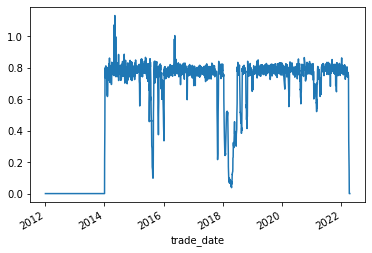

In [2514]:
size_df_new.sum(axis = 1).plot()

In [2555]:
turnover_df = signal_df.shift(1).copy()
turnover_df[turnover_df == 1] = -0.002

In [2609]:
trial_pnl_df = portfolio.alpha_pnl_df.copy()
trial_size_df = portfolio.alpha_sizing_df.copy()

In [2610]:
(trial_pnl_df + (turnover_df * trial_size_df.shift(1)).fillna(0.0)).iloc[:, 1].dropna()

MemoryError: Unable to allocate 365. MiB for an array with shape (19175, 2497) and data type float64

In [2612]:
turnover_df

identifier,"(000004, 2016-11-18 00:00:00, 0.6588112861721704)","(000004, 2019-07-05 00:00:00, 0.5367766558332782)","(000004, 2020-05-12 00:00:00, 0.5907757635406279)","(000004, 2020-05-21 00:00:00, 0.5836654871682804)","(000004, 2020-05-28 00:00:00, 0.5712158226045411)","(000004, 2020-06-22 00:00:00, 0.5334496594730704)","(000006, 2014-03-13 00:00:00, 0.468058845367968)","(000006, 2014-03-24 00:00:00, 0.486211077053383)","(000006, 2014-04-23 00:00:00, 0.4829681343852036)","(000006, 2014-05-08 00:00:00, 0.4820169810628364)",...,"(688687, 2022-02-07 00:00:00, 0.5520527207063184)","(688687, 2022-03-03 00:00:00, 0.5075005890751428)","(688689, 2022-01-07 00:00:00, 0.4867311084049925)","(688689, 2022-02-11 00:00:00, 0.49429554871902537)","(688698, 2021-03-30 00:00:00, 0.514086857640361)","(688698, 2021-06-29 00:00:00, 0.5138021763076381)","(688698, 2021-07-30 00:00:00, 0.47099383220335084)","(688698, 2021-08-27 00:00:00, 0.49819469231238456)","(688698, 2021-09-27 00:00:00, 0.4883512765135041)","(688698, 2022-03-03 00:00:00, 0.5122074909865084)"
trade_date,,,,,,,,,,,,,,,,,,,,,
2012-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-04-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-04-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2597]:
portfolio.alpha_pnl_df.shape

(2497, 19175)

In [2596]:
turnover_df.shape

(2497, 19175)

In [2587]:
alpha_pnl_df + (turnover_df.mul(size_df.shift(1))).fillna(0.0)

MemoryError: Unable to allocate 365. MiB for an array with shape (19175, 2497) and data type float64

In [2572]:
(alpha_pnl_df.iloc[:, 1] + (turnover_df.iloc[:, 1] * size_df.iloc[:, 1]).shift(1).fillna(0.0)).dropna()

trade_date
2019-07-09   -0.000148
2019-07-10   -0.000244
2019-07-11    0.001012
2019-07-12   -0.000377
2019-07-15   -0.000266
2019-07-16    0.000030
2019-07-17    0.000000
2019-07-18   -0.000089
2019-07-19    0.000089
dtype: float64

In [2550]:
size_df.iloc[:, 1].dropna()

trade_date
2019-07-08    0.015000
2019-07-09    0.014882
2019-07-10    0.014638
2019-07-11    0.015650
2019-07-12    0.015273
2019-07-15    0.015007
2019-07-16    0.015037
2019-07-17    0.015037
2019-07-18    0.014948
2019-07-19    0.015037
2019-07-22    0.014483
2019-07-23    0.014261
2019-07-24    0.014416
2019-07-25    0.014091
2019-07-26    0.013966
Name: (000004, 2019-07-05 00:00:00, 0.5440166906640823), dtype: float64

In [2551]:
alpha_pnl_df.iloc[:, 1].dropna()

trade_date
2019-07-09   -0.000118
2019-07-10   -0.000244
2019-07-11    0.001012
2019-07-12   -0.000377
2019-07-15   -0.000266
2019-07-16    0.000030
2019-07-17    0.000000
2019-07-18   -0.000089
2019-07-19    0.000089
Name: (000004, 2019-07-05 00:00:00, 0.5440166906640823), dtype: float64

In [2544]:
return_df_new.where(~signal_df.shift(1).isna(), -0.002)

,"(000004, 2016-11-18 00:00:00, 0.6689302590250213)","(000004, 2019-07-05 00:00:00, 0.5440166906640823)","(000004, 2020-05-12 00:00:00, 0.5950039340850833)","(000004, 2020-05-21 00:00:00, 0.6140016168489634)","(000004, 2020-05-28 00:00:00, 0.5758909658736368)","(000004, 2020-06-22 00:00:00, 0.5369071806908121)","(000004, 2020-11-06 00:00:00, 0.4576175069808501)","(000004, 2021-07-21 00:00:00, 0.46547624499912893)","(000006, 2014-04-23 00:00:00, 0.484373459629352)","(000006, 2014-05-08 00:00:00, 0.4867125517608503)",...,"(300264, 2016-05-16 00:00:00, 0.5274051712920484)","(300233, 2016-05-16 00:00:00, 0.5347440686523967)","(002216, 2016-05-16 00:00:00, 0.533841935378085)","(000573, 2016-05-16 00:00:00, 0.5898903949308925)","(300051, 2016-05-16 00:00:00, 0.5801222339016168)","(300056, 2016-05-16 00:00:00, 0.6314322915461443)","(300092, 2016-05-16 00:00:00, 0.6349445915000284)","(300095, 2016-05-16 00:00:00, 0.5939961331433484)","(002184, 2016-11-17 00:00:00, 0.4845341890180582)","(000529, 2016-11-17 00:00:00, 0.527196935389461)"
trade_date,,,,,,,,,,,,,,,,,,,,,
2012-01-04,-0.002,-0.002,-0.002,-0.002,-0.002,-0.002,-0.002,-0.002,-0.002,-0.002,...,-0.002,-0.002,-0.002,-0.002,-0.002,-0.002,-0.002,-0.002,-0.002,-0.002
2012-01-05,-0.002,-0.002,-0.002,-0.002,-0.002,-0.002,-0.002,-0.002,-0.002,-0.002,...,-0.002,-0.002,-0.002,-0.002,-0.002,-0.002,-0.002,-0.002,-0.002,-0.002
2012-01-06,-0.002,-0.002,-0.002,-0.002,-0.002,-0.002,-0.002,-0.002,-0.002,-0.002,...,-0.002,-0.002,-0.002,-0.002,-0.002,-0.002,-0.002,-0.002,-0.002,-0.002
2012-01-09,-0.002,-0.002,-0.002,-0.002,-0.002,-0.002,-0.002,-0.002,-0.002,-0.002,...,-0.002,-0.002,-0.002,-0.002,-0.002,-0.002,-0.002,-0.002,-0.002,-0.002
2012-01-10,-0.002,-0.002,-0.002,-0.002,-0.002,-0.002,-0.002,-0.002,-0.002,-0.002,...,-0.002,-0.002,-0.002,-0.002,-0.002,-0.002,-0.002,-0.002,-0.002,-0.002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-08,-0.002,-0.002,-0.002,-0.002,-0.002,-0.002,-0.002,-0.002,-0.002,-0.002,...,-0.002,-0.002,-0.002,-0.002,-0.002,-0.002,-0.002,-0.002,-0.002,-0.002
2022-04-11,-0.002,-0.002,-0.002,-0.002,-0.002,-0.002,-0.002,-0.002,-0.002,-0.002,...,-0.002,-0.002,-0.002,-0.002,-0.002,-0.002,-0.002,-0.002,-0.002,-0.002
2022-04-12,-0.002,-0.002,-0.002,-0.002,-0.002,-0.002,-0.002,-0.002,-0.002,-0.002,...,-0.002,-0.002,-0.002,-0.002,-0.002,-0.002,-0.002,-0.002,-0.002,-0.002


In [2536]:
return_df_new

,"(000004, 2016-11-18 00:00:00, 0.6689302590250213)","(000004, 2019-07-05 00:00:00, 0.5440166906640823)","(000004, 2020-05-12 00:00:00, 0.5950039340850833)","(000004, 2020-05-21 00:00:00, 0.6140016168489634)","(000004, 2020-05-28 00:00:00, 0.5758909658736368)","(000004, 2020-06-22 00:00:00, 0.5369071806908121)","(000004, 2020-11-06 00:00:00, 0.4576175069808501)","(000004, 2021-07-21 00:00:00, 0.46547624499912893)","(000006, 2014-04-23 00:00:00, 0.484373459629352)","(000006, 2014-05-08 00:00:00, 0.4867125517608503)",...,"(300264, 2016-05-16 00:00:00, 0.5274051712920484)","(300233, 2016-05-16 00:00:00, 0.5347440686523967)","(002216, 2016-05-16 00:00:00, 0.533841935378085)","(000573, 2016-05-16 00:00:00, 0.5898903949308925)","(300051, 2016-05-16 00:00:00, 0.5801222339016168)","(300056, 2016-05-16 00:00:00, 0.6314322915461443)","(300092, 2016-05-16 00:00:00, 0.6349445915000284)","(300095, 2016-05-16 00:00:00, 0.5939961331433484)","(002184, 2016-11-17 00:00:00, 0.4845341890180582)","(000529, 2016-11-17 00:00:00, 0.527196935389461)"
trade_date,,,,,,,,,,,,,,,,,,,,,
2012-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-05,-0.073325,-0.073325,-0.073325,-0.073325,-0.073325,-0.073325,-0.073325,-0.073325,-0.012315,-0.012315,...,-0.063281,-0.042298,-0.083333,-0.029650,-0.099578,-0.028518,-0.091575,-0.048820,-0.065319,-0.023847
2012-01-06,0.004093,0.004093,0.004093,0.004093,0.004093,0.004093,0.004093,0.004093,-0.002494,-0.002494,...,0.022519,0.020833,-0.040727,0.011111,-0.024367,0.038499,-0.016129,0.017109,0.013311,0.006515
2012-01-09,0.046196,0.046196,0.046196,0.046196,0.046196,0.046196,0.046196,0.046196,0.027500,0.027500,...,0.041599,0.046531,0.007961,0.041209,0.038425,0.039388,0.035246,0.034483,0.054187,0.035599
2012-01-10,0.059740,0.059740,0.059740,0.059740,0.059740,0.059740,0.059740,0.059740,0.036496,0.036496,...,0.030540,0.035101,0.047386,0.034301,0.049954,0.022737,0.040380,0.040650,0.046729,0.026563
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-08,-0.029351,-0.029351,-0.029351,-0.029351,-0.029351,-0.029351,-0.029351,-0.029351,0.005792,0.005792,...,-0.095017,-0.010689,-0.016075,-0.008639,0.027985,-0.018803,-0.036254,-0.007686,-0.027540,-0.031299
2022-04-11,-0.046684,-0.046684,-0.046684,-0.046684,-0.046684,-0.046684,-0.046684,-0.046684,-0.042226,-0.042226,...,-0.097311,0.000300,0.074200,-0.091503,-0.021779,-0.060976,-0.026123,-0.041308,-0.034180,-0.011309
2022-04-12,0.025042,0.025042,0.025042,0.025042,0.025042,0.025042,0.025042,0.025042,-0.016032,-0.016032,...,0.014184,-0.049205,-0.004436,-0.002398,0.012987,0.037106,0.030043,0.028725,0.028311,0.029412


In [2515]:
        alpha_pnl_df = size_df_new.shift(1).apply(lambda x: x * return_df[x.name[0]], axis = 0)
    
        hedge_sizing_df = size_df_new * -1
        hedge_pnl_df = hedge_sizing_df * hedge_return_df
        
        pnl_df = pd.concat([alpha_pnl_df, hedge_pnl_df], axis = 1)

        cumpnl = pnl_df.sum(axis = 1).cumsum()
        cumpnl = cumpnl.replace(0.0, np.nan).dropna()
        cumpnl.iplot(kind='line')

C:\Users\user1\anaconda3\lib\site-packages\pandas\core\indexes\base.py:4024: RuntimeWarning:

'<' not supported between instances of 'tuple' and 'Timestamp', sort order is undefined for incomparable objects



In [2516]:
pnl_df.sum(axis = 1).mean() * 250

0.2901385436613228

In [2517]:
pnl_df.sum(axis = 1)[pnl_df.sum(axis = 1)!=0].mean() * 252

0.3635001249728728

In [2421]:
turnover_df = size_df_new.copy()

In [2411]:
turnover_df = turnover_df.where(turnover_df.isna(), 1.0)

In [2415]:
turnover_df = turnover_df.where(turnover_df == 1.0, 0.0)

In [2417]:
turnover_df.diff().abs().sum(axis = 0)

(000004, 2016-11-18 00:00:00, 0.6588112861721704)     2.0
(000004, 2019-07-05 00:00:00, 0.5367766558332782)     2.0
(000004, 2020-05-12 00:00:00, 0.5907757635406279)     2.0
(000004, 2020-05-21 00:00:00, 0.5836654871682804)     2.0
(000004, 2020-05-28 00:00:00, 0.5712158226045411)     2.0
                                                     ... 
(688698, 2021-06-29 00:00:00, 0.5138021763076381)     2.0
(688698, 2021-07-30 00:00:00, 0.47099383220335084)    2.0
(688698, 2021-08-27 00:00:00, 0.49819469231238456)    2.0
(688698, 2021-09-27 00:00:00, 0.4883512765135041)     2.0
(688698, 2022-03-03 00:00:00, 0.5122074909865084)     2.0
Length: 19175, dtype: float64

In [2422]:
turnover_df.shape

(2497, 19175)

In [2423]:
turnover_df.dropna(how = "all", axis = 1)

,"(000004, 2016-11-18 00:00:00, 0.6588112861721704)","(000004, 2019-07-05 00:00:00, 0.5367766558332782)","(000004, 2020-05-12 00:00:00, 0.5907757635406279)","(000004, 2020-05-21 00:00:00, 0.5836654871682804)","(000004, 2020-05-28 00:00:00, 0.5712158226045411)","(000004, 2020-06-22 00:00:00, 0.5334496594730704)","(000006, 2014-03-13 00:00:00, 0.468058845367968)","(000006, 2014-03-24 00:00:00, 0.486211077053383)","(000006, 2014-04-23 00:00:00, 0.4829681343852036)","(000006, 2018-07-23 00:00:00, 0.4621211021891939)",...,"(688687, 2022-02-07 00:00:00, 0.5520527207063184)","(688687, 2022-03-03 00:00:00, 0.5075005890751428)","(688689, 2022-01-07 00:00:00, 0.4867311084049925)","(688689, 2022-02-11 00:00:00, 0.49429554871902537)","(688698, 2021-03-30 00:00:00, 0.514086857640361)","(688698, 2021-06-29 00:00:00, 0.5138021763076381)","(688698, 2021-07-30 00:00:00, 0.47099383220335084)","(688698, 2021-08-27 00:00:00, 0.49819469231238456)","(688698, 2021-09-27 00:00:00, 0.4883512765135041)","(688698, 2022-03-03 00:00:00, 0.5122074909865084)"
trade_date,,,,,,,,,,,,,,,,,,,,,
2012-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-04-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-04-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2425]:
18863*0.002*0.01

0.37726

In [2337]:
size_df_new.loc[pd.Timestamp(2014,1,3):,stop_list]

,"(300310, 2014-01-02 00:00:00, 0.5161492792215538)","(002635, 2014-01-02 00:00:00, 0.5991056401032901)","(600761, 2014-01-02 00:00:00, 0.48282328773040384)","(002623, 2014-01-02 00:00:00, 0.561027353882931)","(002093, 2014-01-02 00:00:00, 0.5376359653675309)","(002286, 2014-01-02 00:00:00, 0.49708771944774144)","(600176, 2014-01-02 00:00:00, 0.5043280368727313)","(300266, 2014-01-02 00:00:00, 0.5059592347612627)","(002637, 2014-01-02 00:00:00, 0.586976288484693)"
trade_date,,,,,,,,,
2014-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2022-04-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-04-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-04-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2318]:
stop_list

[('300310', Timestamp('2014-01-02 00:00:00'), 0.5161492792215538),
 ('002635', Timestamp('2014-01-02 00:00:00'), 0.5991056401032901),
 ('600761', Timestamp('2014-01-02 00:00:00'), 0.48282328773040384),
 ('002623', Timestamp('2014-01-02 00:00:00'), 0.561027353882931),
 ('002093', Timestamp('2014-01-02 00:00:00'), 0.5376359653675309),
 ('002286', Timestamp('2014-01-02 00:00:00'), 0.49708771944774144),
 ('600176', Timestamp('2014-01-02 00:00:00'), 0.5043280368727313),
 ('300266', Timestamp('2014-01-02 00:00:00'), 0.5059592347612627),
 ('002637', Timestamp('2014-01-02 00:00:00'), 0.586976288484693)]

In [2243]:
portfolio.sizing_df.sum(axis = 1).iplot()

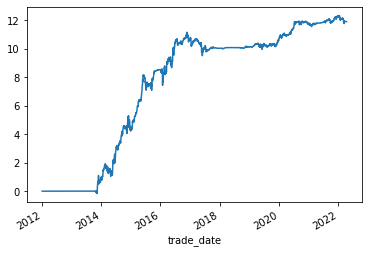

In [2128]:
equal_size_portfolio_500_small.get_pnl_curve(0.01, 15, 1, "fixed")

In [2171]:
portfolio.pnl_df.sum(axis = 1).cumsum()

trade_date
2012-01-04    0.000000
2012-01-05    0.000000
2012-01-06    0.000000
2012-01-09    0.000000
2012-01-10    0.000000
                ...   
2022-04-08    9.927907
2022-04-11    9.927907
2022-04-12    9.927907
2022-04-13    9.927907
2022-04-14    9.927907
Length: 2497, dtype: float64